In [1]:
from typing import List

import os
import json

import h5py
import numpy as np

# for getting all combinations of the highres choice
from itertools import combinations

# set a random number seed for reproducibility
np.random.seed(0)

In [2]:
# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

In [3]:
# if you are in the root folder, don't run this line
os.chdir("..")
os.getcwd()

'/home/jibancat/Documents/PYTHON/lya_mf_emulator'

In [4]:
# MF emulator related modules
from lyaemu.mf_trainset_optimize import TrainSetOptimize

# for normalize the input parameter to a unit cube
from lyaemu.latin_hypercube import map_to_unit_cube_list

def input_normalize(
    params: np.ndarray, param_limits: np.ndarray
) -> np.ndarray:
    """
    Map the parameters onto a unit cube so that all the variations are
    similar in magnitude.
    
    :param params: (n_points, n_dims) parameter vectors
    :param param_limits: (n_dim, 2) param_limits is a list 
        of parameter limits.
    :return: params_cube, (n_points, n_dims) parameter vectors 
        in a unit cube.
    """
    nparams = np.shape(params)[1]
    params_cube = map_to_unit_cube_list(params, param_limits)
    assert params_cube.shape[1] == nparams

    return params_cube

In [5]:
def plot_parameters(
    X_train: List[np.ndarray],
    parameter_names: List[str] = [
        r"$n_s$",
        r"$A_p$",
        r"$\mathrm{He}_{re_i}$",
        r"$\mathrm{He}_{re_f}$",
        r"$\alpha_q$",
        r"$h$",
        r"$\Omega_m$",
        r"$\mathrm{H}_\mathrm{reionz}$",
        r"$\mathrm{BH}_{feedback}$",
    ],
):
    """
    Plot the selected samples with all other samples in the input data.
    This would enable us to investigate locations of the selected training samples.
    """
    n_parameters = X_train[0].shape[1]

    for i in range(n_parameters):
        for j in range(i + 1, n_parameters):
            plt.scatter(
                X_train[0][:, i],
                X_train[0][:, j],
                marker="o",
                label="LowRes training data",
                color="C0",
                s=100,
            )
            plt.scatter(
                X_train[1][:, i],
                X_train[1][:, j],
                marker="o",
                label="HighRes training data",
                color="C1",
                s=40,
            )
            plt.legend()
            plt.xlabel(parameter_names[i])
            plt.ylabel(parameter_names[j])
            plt.show()

# Optimize the choice of high-res using low-fidelity only emulator (redshifts)

Low-fidelity only emulator -

    f ~ GP(X_train, Y_train)

    X_train = input parameters in a unit cube
    Y_train = log10(flux power spectra)
    
    loss = sum_{zi}^{zf} (MSE(z))

In [6]:
filename = "data/emu_30mpc_lores/cc_emulator_flux_vectors_tau1000000.hdf5"
json_name = "data/emu_30mpc_lores/emulator_params.json"

In [7]:
# read param file and the flux power spectra
with open(json_name, "r") as param:
    param = json.load(param)
    
f = h5py.File(filename, "r")

print("All keys", f.keys())

print("Shape of redshfits", f["zout"].shape)
print("Shape of params", f["params"].shape)
print("Shape of kfkms", f["kfkms"].shape)
print("Shape of kfmpc", f["kfmpc"].shape)
print("Shape of flux vectors", f["flux_vectors"].shape)

# use kfmpc so all redshifts use the same k bins
kfmpc = f["kfmpc"][()]

zout = f["zout"][()]

# flux power spectra, all redshifts
flux_vectors = f["flux_vectors"][()]

# read flux power spectrum at ith redshift
# flux power spectrum | z = ?
get_flux_vector_at_z = lambda i : flux_vectors[:, i * len(kfmpc) : (i + 1) * len(kfmpc)]

last_flux_vector = get_flux_vector_at_z(len(zout) - 1)
assert len(last_flux_vector) == f["params"].shape[0]
assert last_flux_vector.shape[1] == len(kfmpc)

first_flux_vector = get_flux_vector_at_z(0)
assert len(first_flux_vector) == f["params"].shape[0]
assert first_flux_vector.shape[1] == len(kfmpc)

All keys <KeysViewHDF5 ['flux_vectors', 'kfkms', 'kfmpc', 'params', 'zout']>
Shape of redshfits (18,)
Shape of params (30, 9)
Shape of kfkms (30, 18, 25)
Shape of kfmpc (25,)
Shape of flux vectors (30, 450)


In [8]:
%%capture
# runs for ~15 mins on my laptop if n_optimization_restarts=5

# select 2 samples out of 30 samples, use 28 samples to validate
# the GP loss
num_selected = 2
n_optimization_restarts = 10

# setup parameter settings
param_limits = np.array(param["param_limits"])
X_train = f["params"][()]

# No need to normalize since only single fidelity
# but it's better to map param to a unit cube to avoid
# ARD hyperparameter optimization searching in a wide
# dynamical range
X = input_normalize(X_train, param_limits=param_limits)
print("[Info] Input parameters are normalized to a unit cube.")

num_samples, _ = X.shape

# looking for all possible combinations
all_combinations = list(combinations(range(num_samples), num_selected))

all_z_loss = []

# loop over all redshifts
for i, z in enumerate(zout):

    # if not log scale, some selections cannot be trained, which might
    # indicate log scale is a better normalization for GP
    Y = np.log10(get_flux_vector_at_z(i))
    print("[Info] Getting flux vector at z = {:.3g} ...".format(z))
    print("[Info] Trun the flux power into log scale.")

    train_opt = TrainSetOptimize(X=X, Y=Y)

    # loop over to get the least loss 2 indices
    # It takes time to loop over all redhifts ...
    all_loss = []

    for j,selected_index in enumerate(all_combinations):

        # need to convert to boolean array
        ind = np.zeros(num_samples, dtype=np.bool)
        ind[np.array(selected_index)] = True

        loss = train_opt.loss(ind, n_optimization_restarts=n_optimization_restarts)

        print("iteration: {} out of {}".format((i, j), (len(zout), len(all_combinations))))

        all_loss.append(loss)

    all_z_loss.append(all_loss)

# [sum over all redshifts] To account for all available redshift,
# we sum the MSE loss from each z. The optimal one should have the
# lowest average MSE loss across all z. 
all_sum_z_loss = np.array(all_z_loss).sum(axis=0)

In [9]:
# find the set of 2 indices best minimize the loss

all_z_selected_index = []

# need to print for all redshifts
for i,z in enumerate(zout):

    all_loss = all_z_loss[i]

    # the optimal one is the one has lowest MSE loss
    selected_index = np.array(all_combinations[np.argmin(all_loss)])

    print("Optimal two ({:2d}, {:2d}) for z = {:.3g}".format(selected_index[0], selected_index[1], z))

    all_z_selected_index.append(selected_index)

# [sum over all redshifts]
selected_index_sum_z = np.array(all_combinations[np.argmin(all_sum_z_loss)])
print("Optimal two (summing over all redshifts) ({:2d}, {:2d})".format(
    selected_index_sum_z[0], selected_index_sum_z[1]))

Optimal two (13, 18) for z = 5.4
Optimal two (10, 13) for z = 5.2
Optimal two ( 3,  4) for z = 5
Optimal two ( 3, 20) for z = 4.8
Optimal two ( 0,  4) for z = 4.6
Optimal two ( 3, 12) for z = 4.4
Optimal two ( 4, 11) for z = 4.2
Optimal two ( 3, 20) for z = 4
Optimal two ( 3, 18) for z = 3.8
Optimal two ( 3, 12) for z = 3.6
Optimal two ( 3, 18) for z = 3.4
Optimal two ( 3, 18) for z = 3.2
Optimal two (10, 28) for z = 3
Optimal two ( 1, 12) for z = 2.8
Optimal two (10, 19) for z = 2.6
Optimal two (13, 21) for z = 2.4
Optimal two (16, 29) for z = 2.2
Optimal two (19, 23) for z = 2
Optimal two (summing over all redshifts) ( 3, 12)


In [10]:
%%capture
# runs ~ 2 mins on my laptop

# search for the 3rd index by conditioning on the optimal two

all_z_next_loss = []
all_z_next_selected_index = []

# loop over all redshifts
for i, selected_index in enumerate(all_z_selected_index):

    # turn integers into a boolean array
    prev_ind = np.zeros(num_samples, dtype=np.bool)
    prev_ind[np.array(selected_index)] = True

    assert np.sum(prev_ind) == len(selected_index)
    
    # this method loop over all index \in {1..30} - {prev_ind}
    # and compute the loss
    next_index, all_next_loss = train_opt.optimize(prev_ind, n_optimization_restarts=n_optimization_restarts)

    # optimal next selection indices
    optimal_index = np.append(selected_index, next_index)

    assert np.where(~prev_ind)[0][np.argmin(all_next_loss)] == next_index

    all_z_next_selected_index.append(optimal_index)
    all_z_next_loss.append(all_next_loss)

In [11]:
%%capture
# [summing over all z]
# runs ~ 2 mins on my laptop

# search for the 3rd index by conditioning on the optimal two

# turn integers into a boolean array
prev_ind = np.zeros(num_samples, dtype=np.bool)
prev_ind[np.array(selected_index_sum_z)] = True

assert np.sum(prev_ind) == len(selected_index_sum_z)

# this method loop over all index \in {1..30} - {prev_ind}
# and compute the loss
next_index, all_next_loss = train_opt.optimize(prev_ind, n_optimization_restarts=n_optimization_restarts)

# optimal next selection indices
optimal_index_sum_z = np.append(selected_index_sum_z, next_index)

assert np.where(~prev_ind)[0][np.argmin(all_next_loss)] == next_index

In [12]:
# print the set of 3 indices best minimize the loss

for i,z in enumerate(zout):

    selected_index = all_z_next_selected_index[i]

    print("Optimal three ({:2d}, {:2d}, {:2d}) for z = {:.3g}".format(selected_index[0], selected_index[1], selected_index[2], z))

print("Optimal three (summing over all redshifts) ({:2d}, {:2d}, {:2d})".format(
    optimal_index_sum_z[0], optimal_index_sum_z[1], optimal_index_sum_z[2]))


Optimal three (13, 18, 24) for z = 5.4
Optimal three (10, 13, 29) for z = 5.2
Optimal three ( 3,  4, 23) for z = 5
Optimal three ( 3, 20, 27) for z = 4.8
Optimal three ( 0,  4,  1) for z = 4.6
Optimal three ( 3, 12, 25) for z = 4.4
Optimal three ( 4, 11, 23) for z = 4.2
Optimal three ( 3, 20, 27) for z = 4
Optimal three ( 3, 18,  4) for z = 3.8
Optimal three ( 3, 12, 25) for z = 3.6
Optimal three ( 3, 18, 28) for z = 3.4
Optimal three ( 3, 18,  4) for z = 3.2
Optimal three (10, 28, 24) for z = 3
Optimal three ( 1, 12,  8) for z = 2.8
Optimal three (10, 19, 27) for z = 2.6
Optimal three (13, 21, 25) for z = 2.4
Optimal three (16, 29,  8) for z = 2.2
Optimal three (19, 23, 26) for z = 2
Optimal three (summing over all redshifts) ( 3, 12,  7)


z = 2


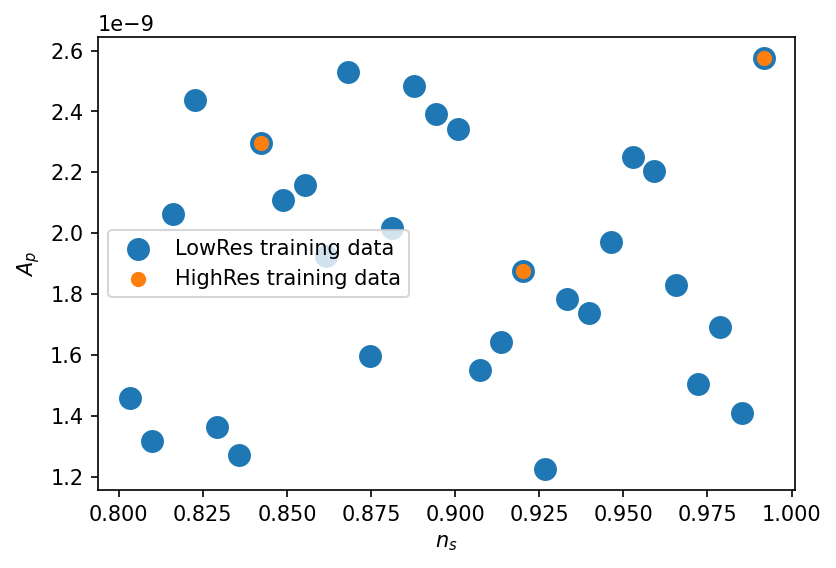

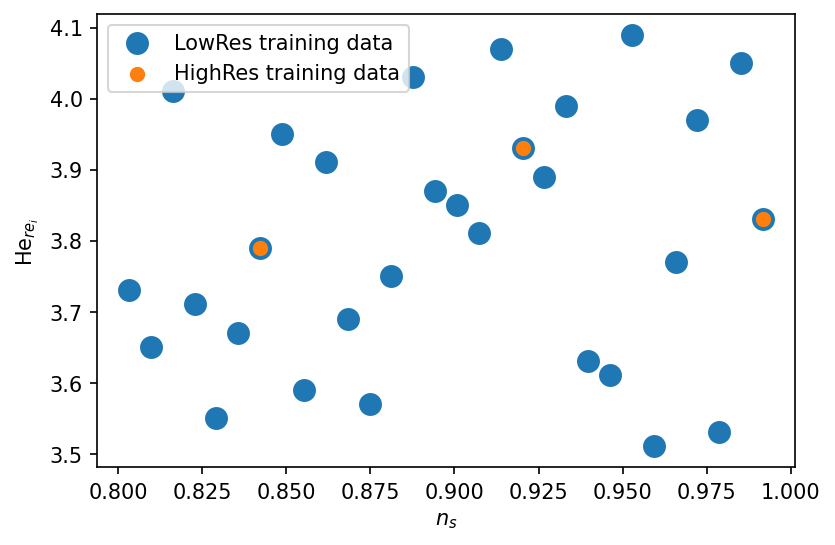

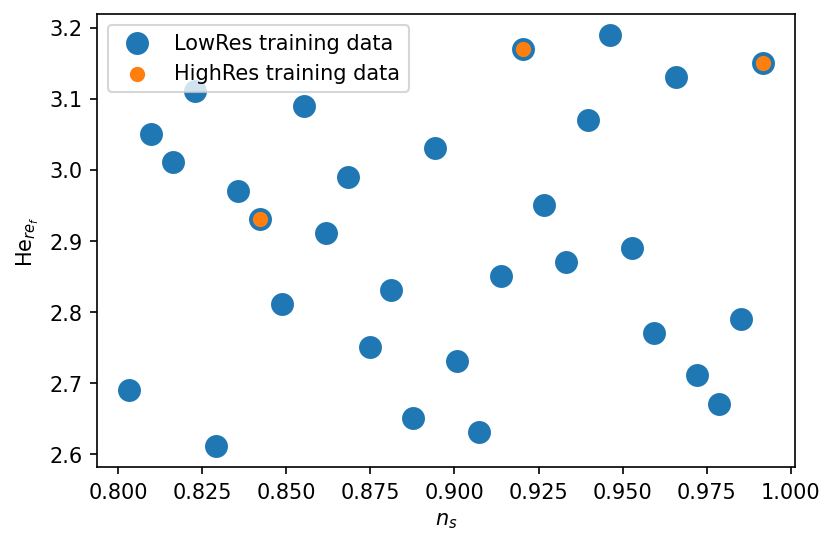

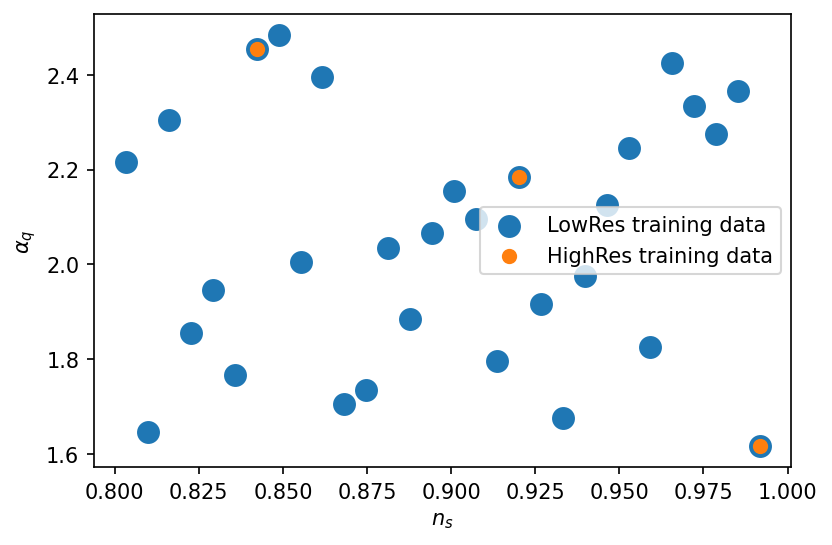

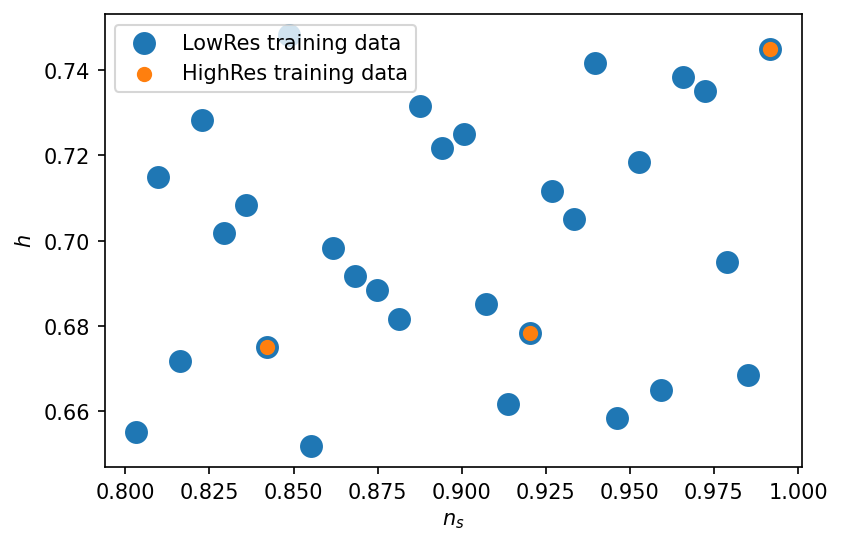

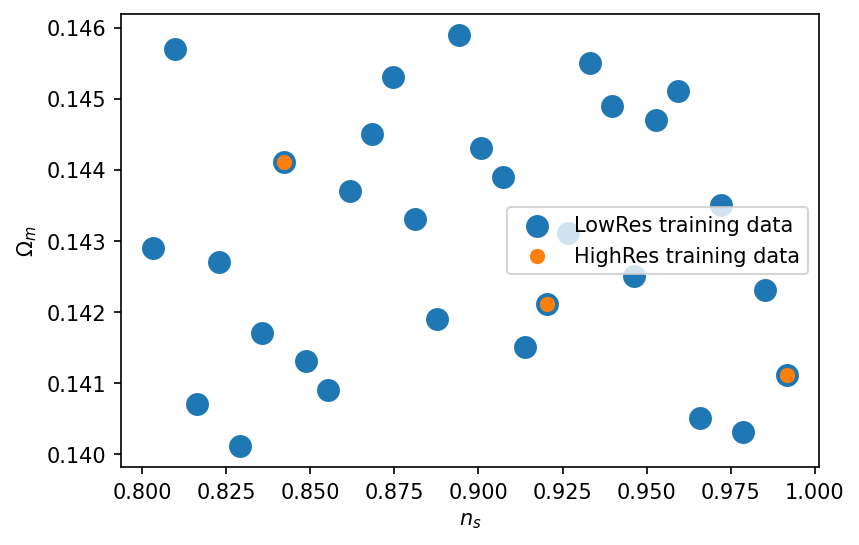

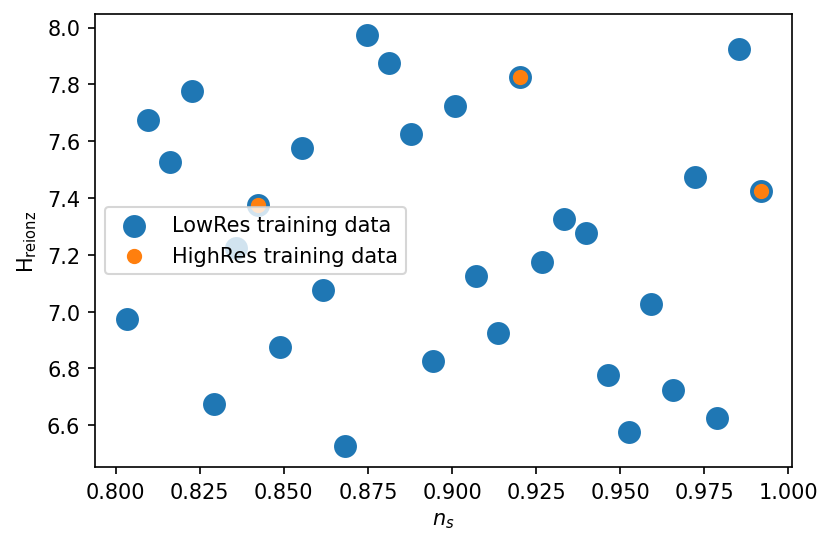

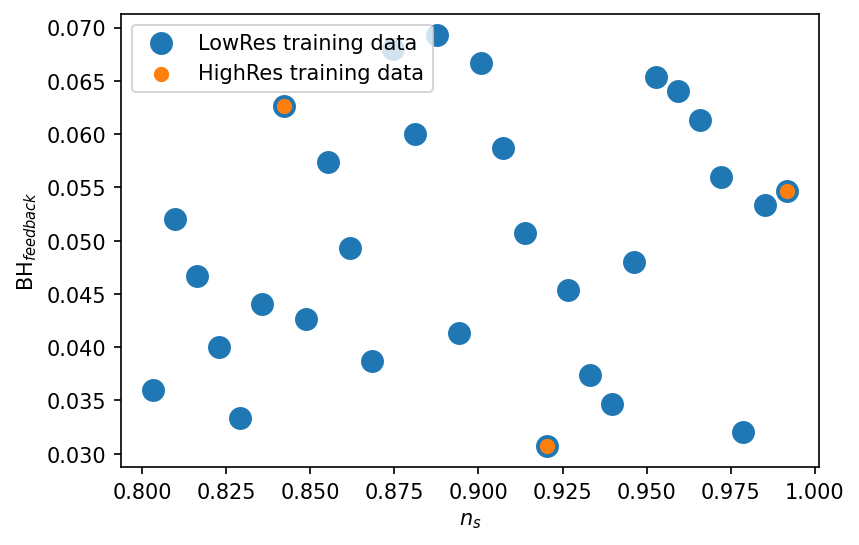

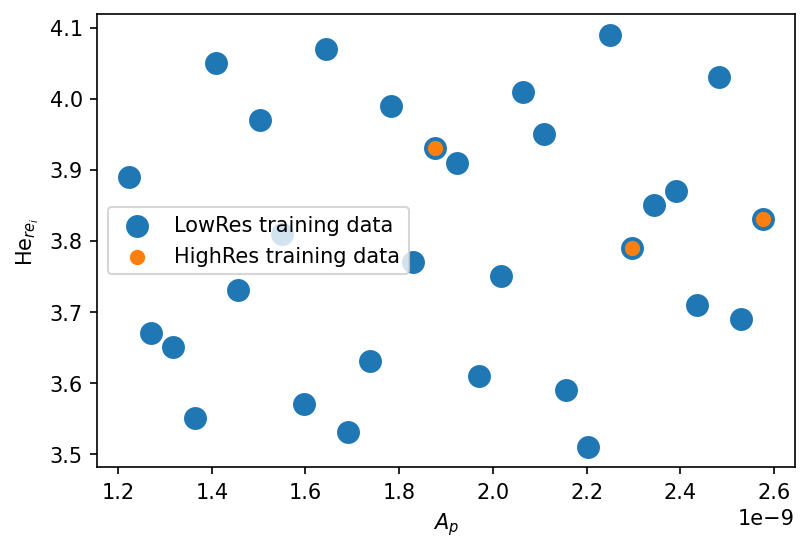

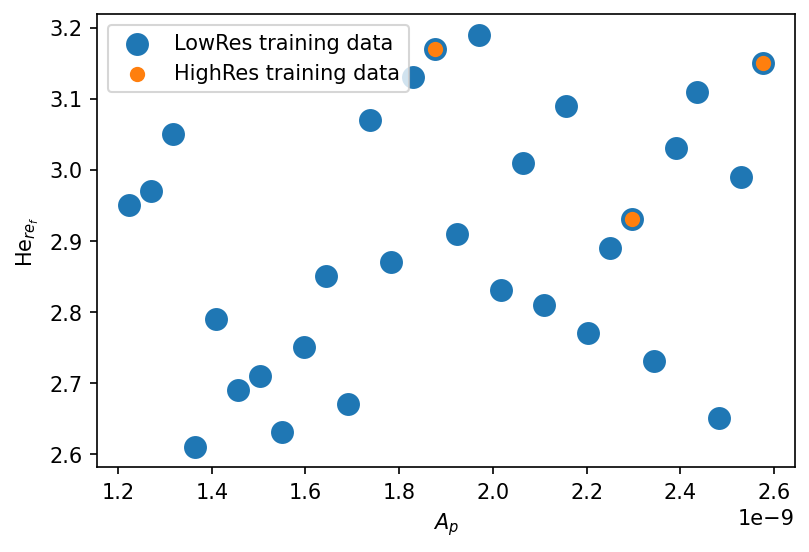

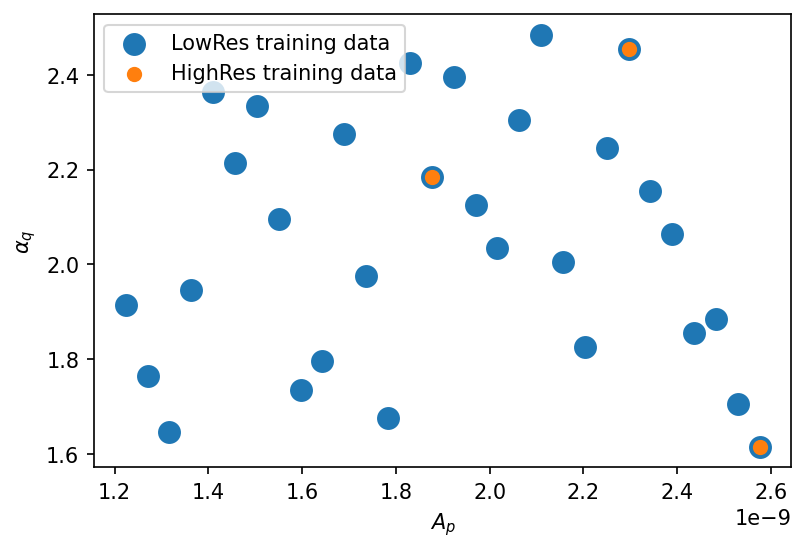

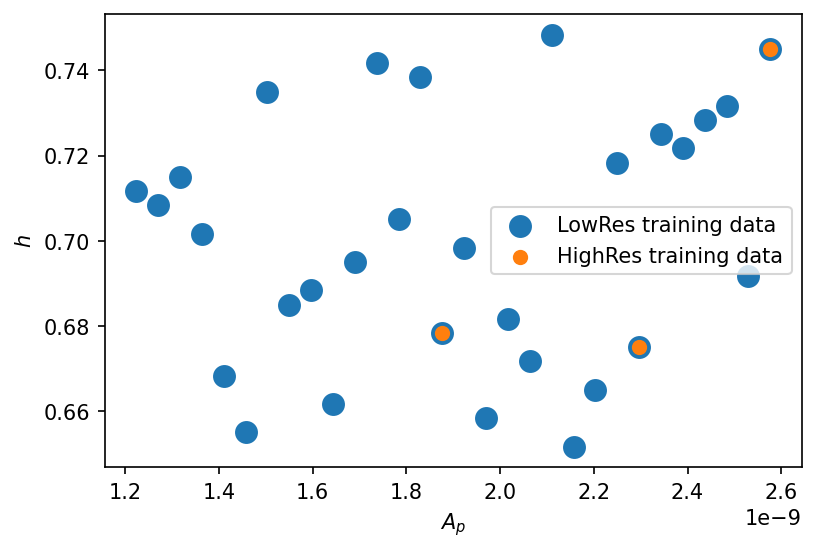

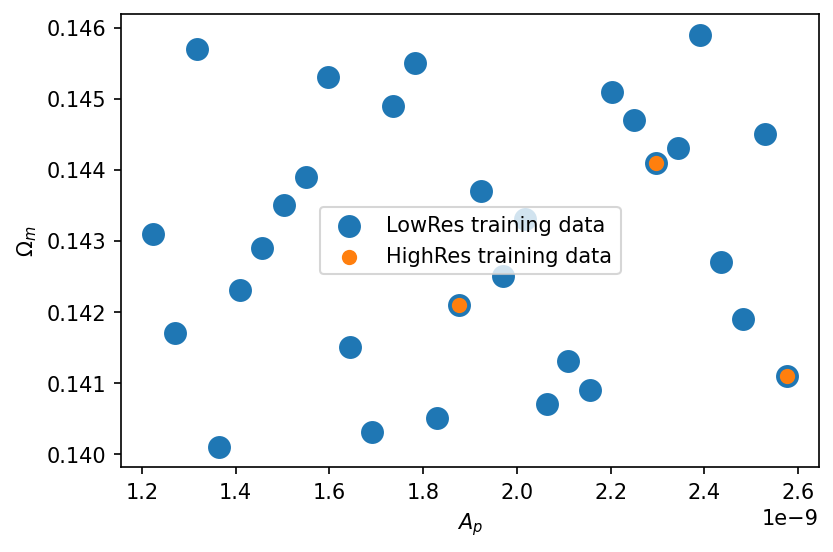

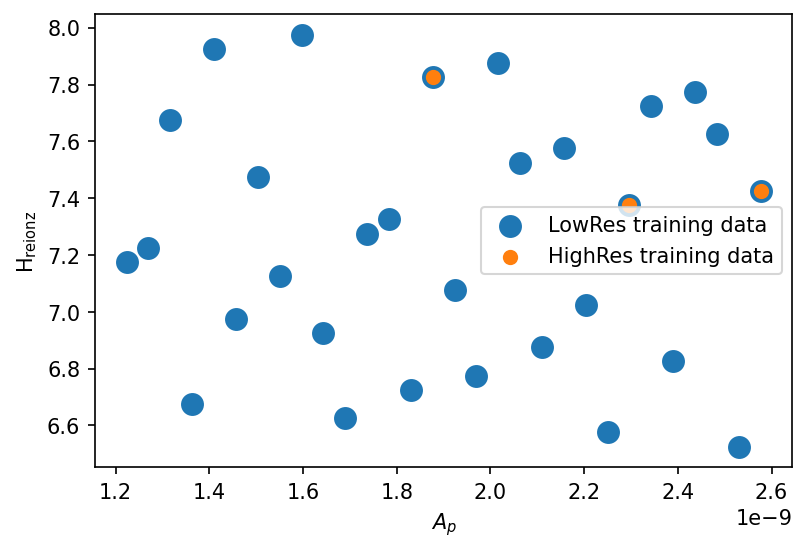

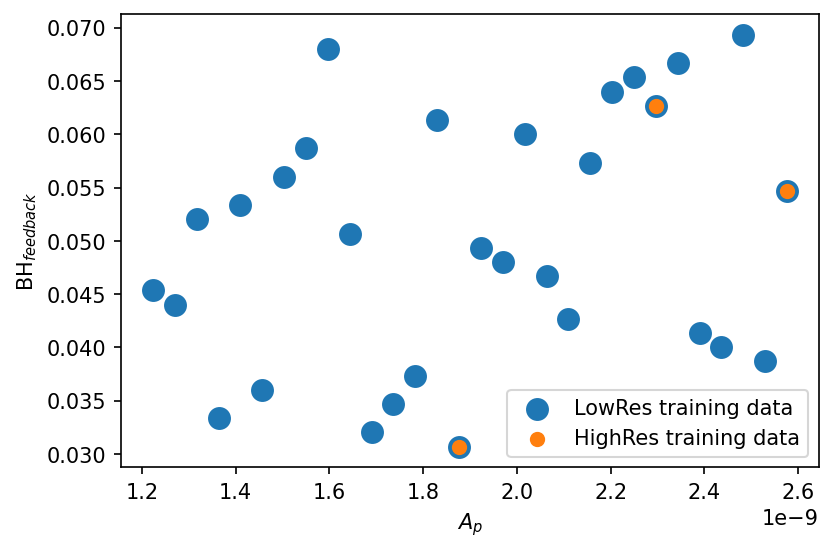

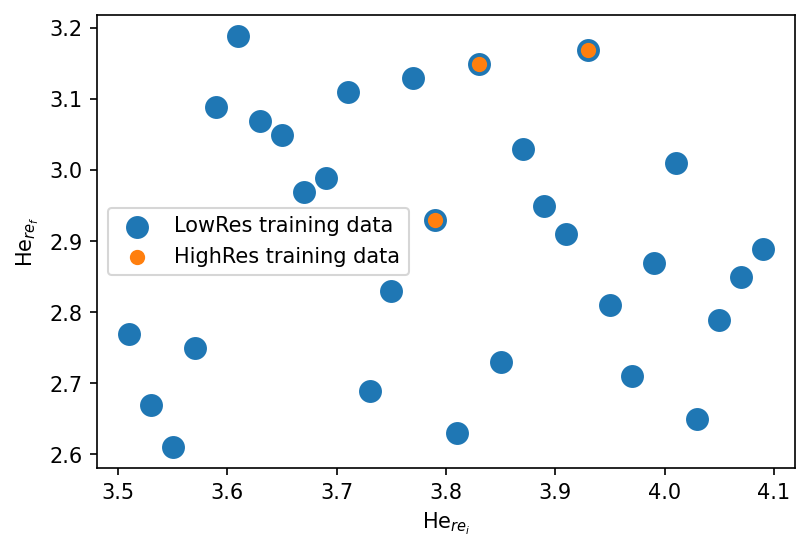

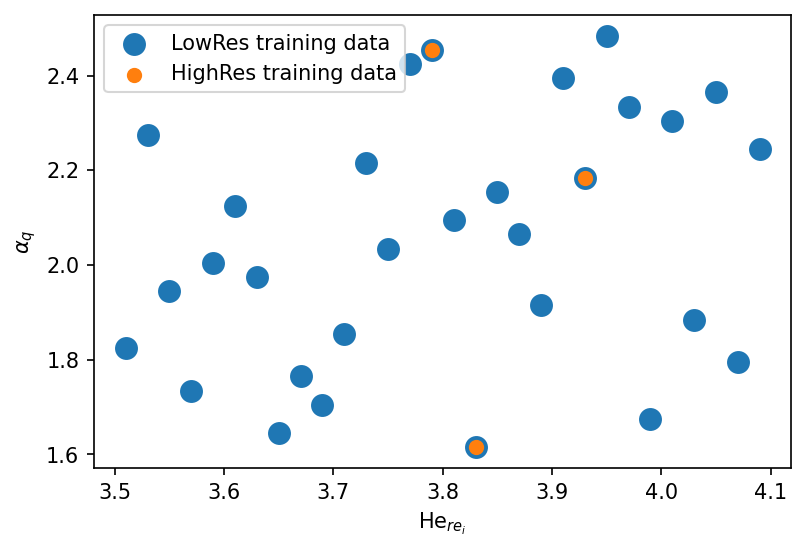

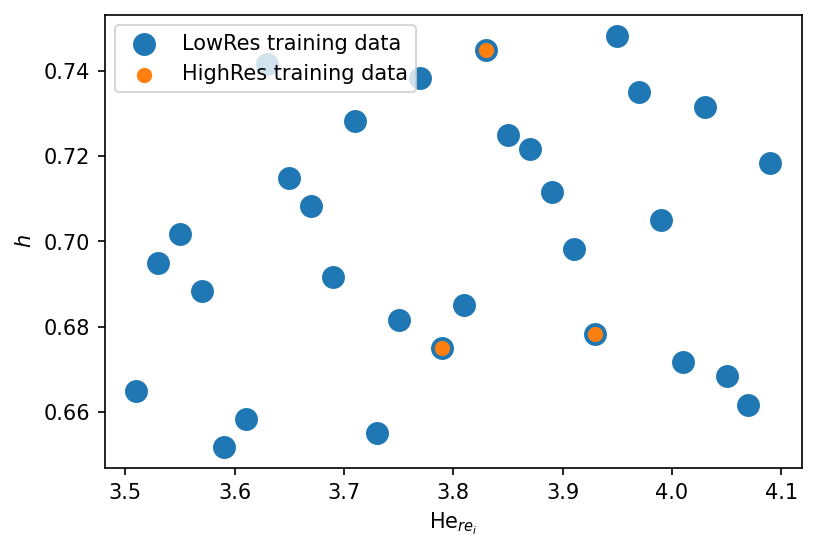

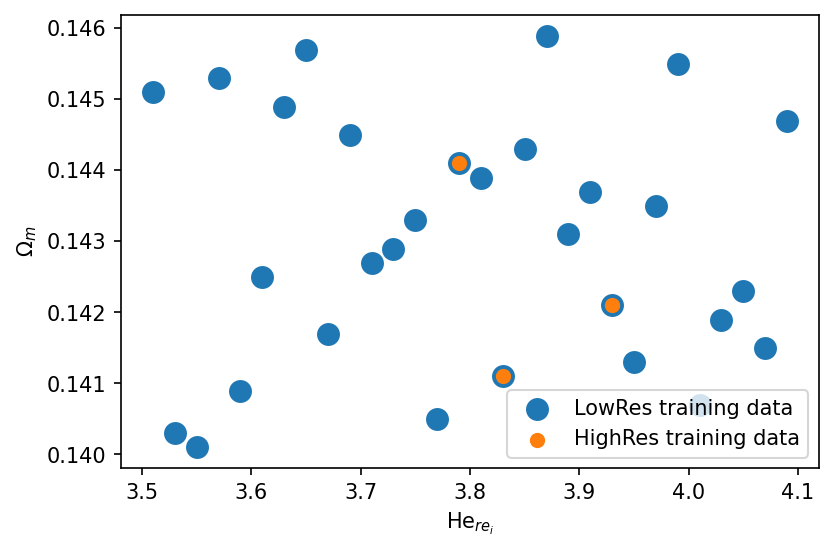

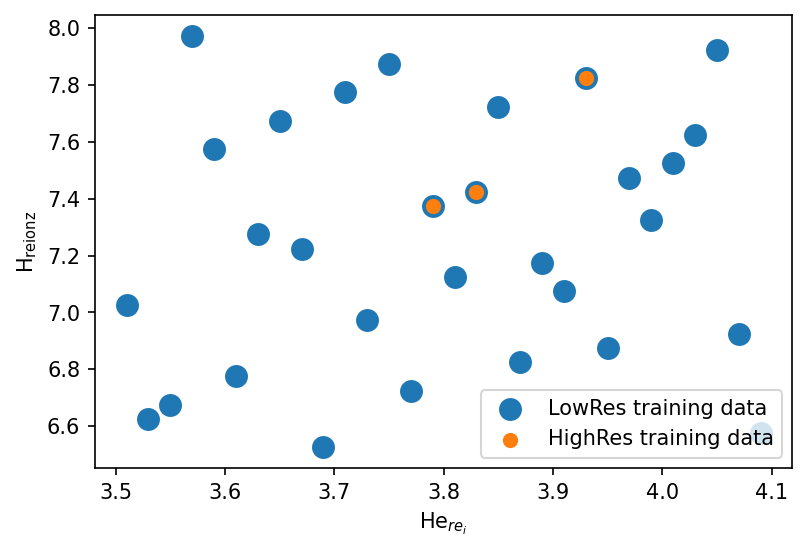

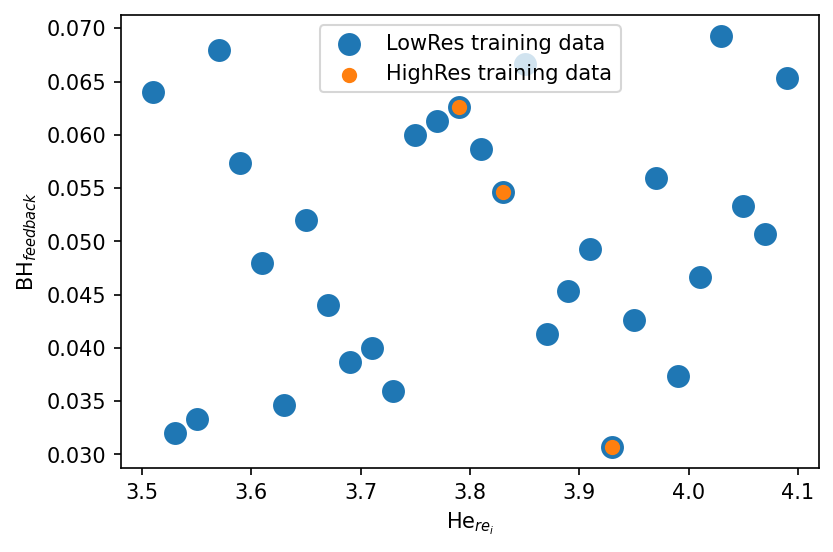

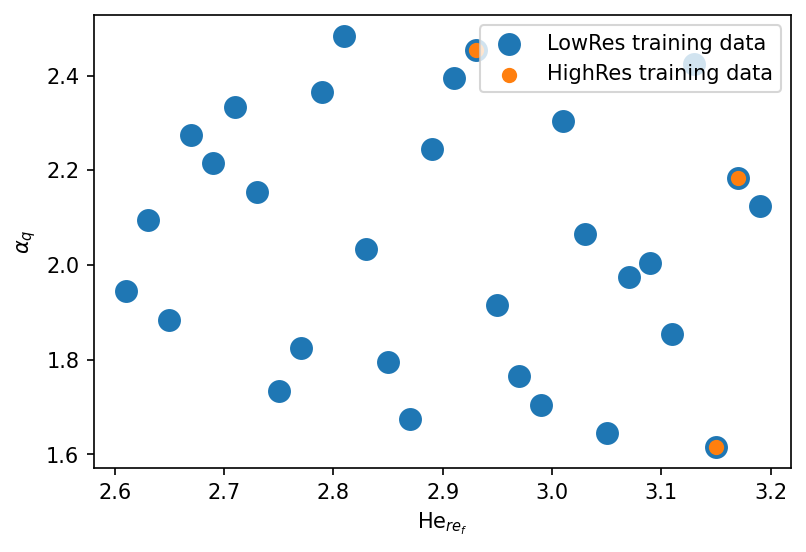

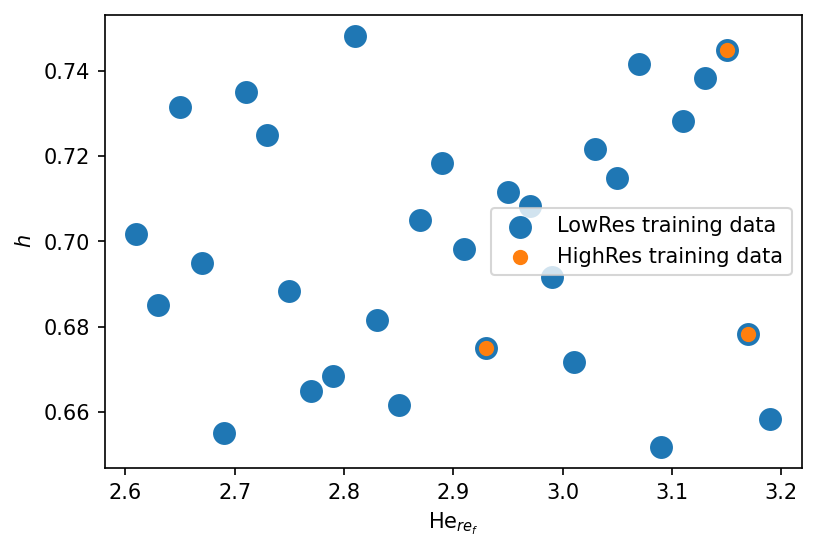

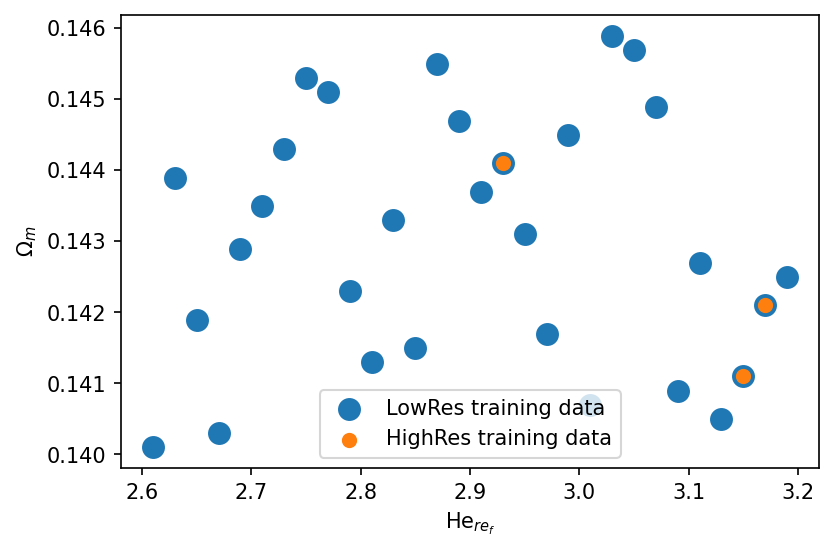

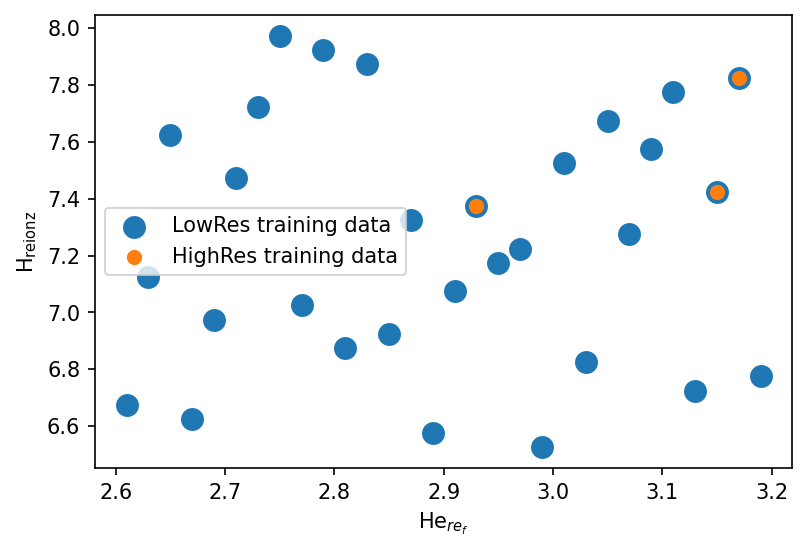

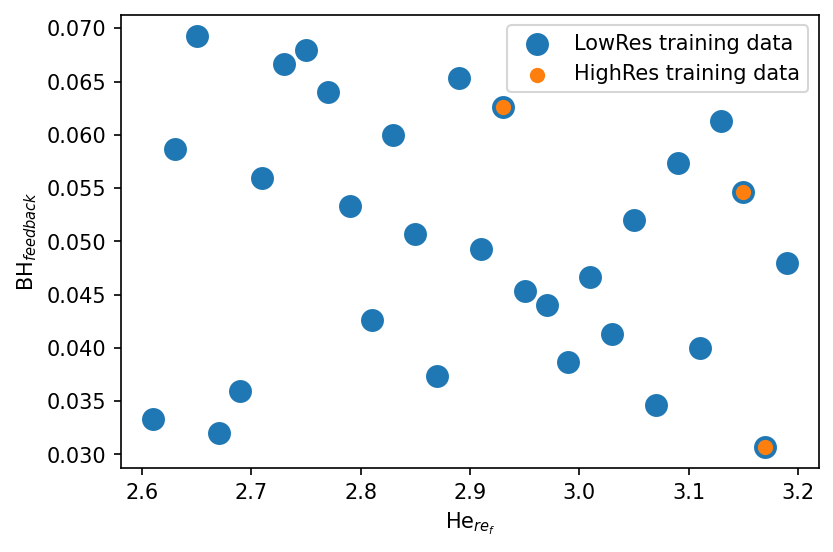

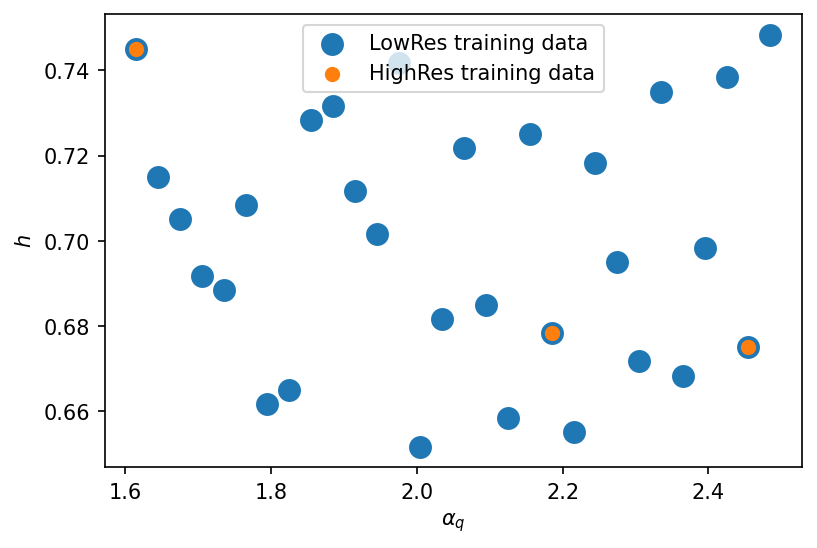

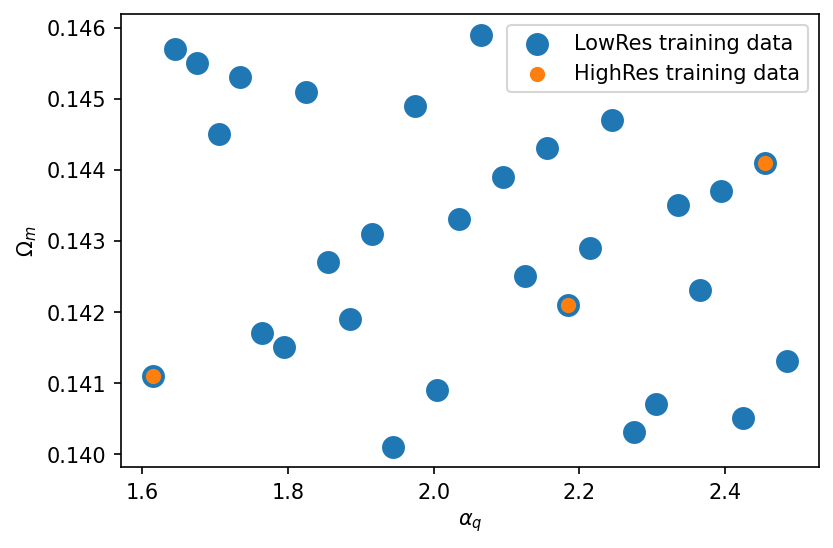

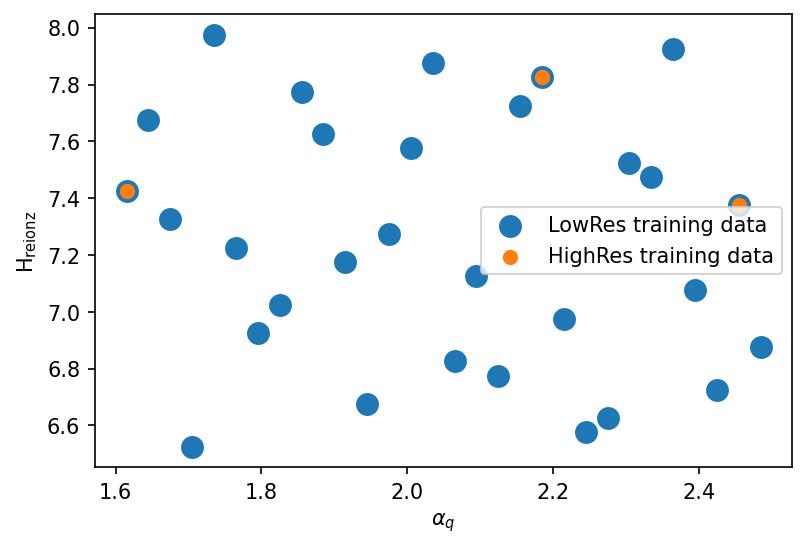

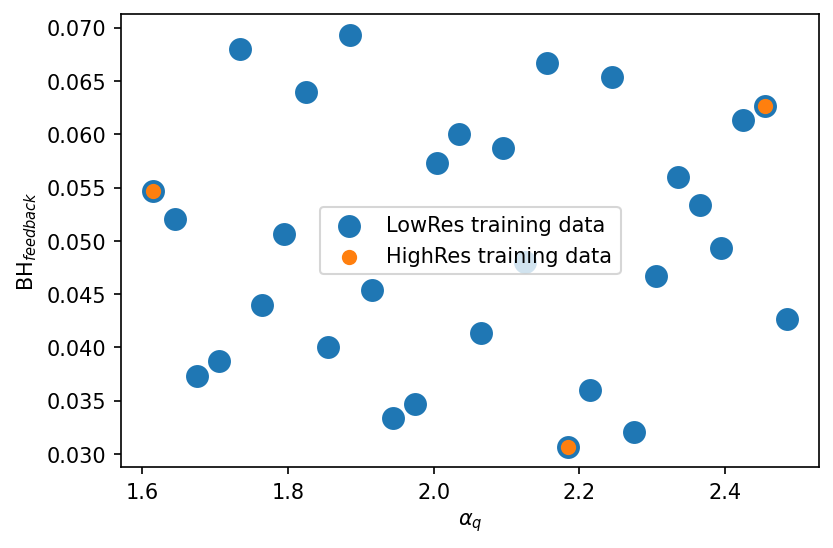

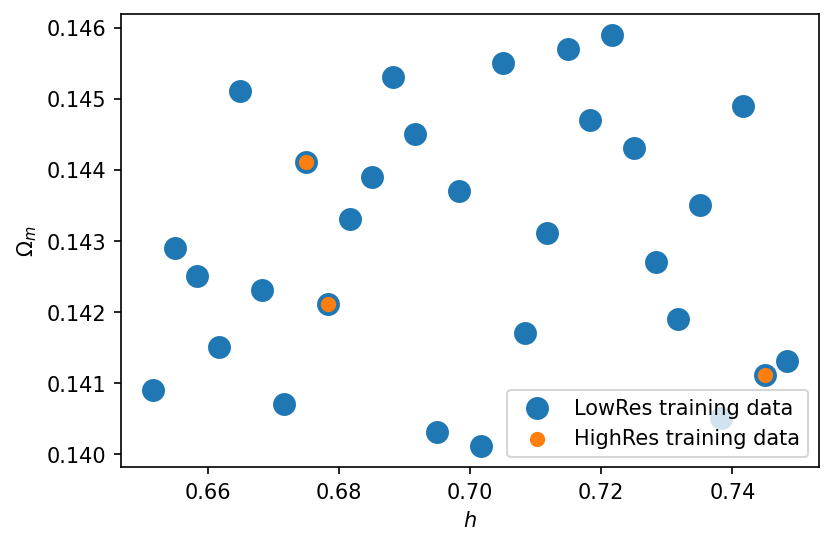

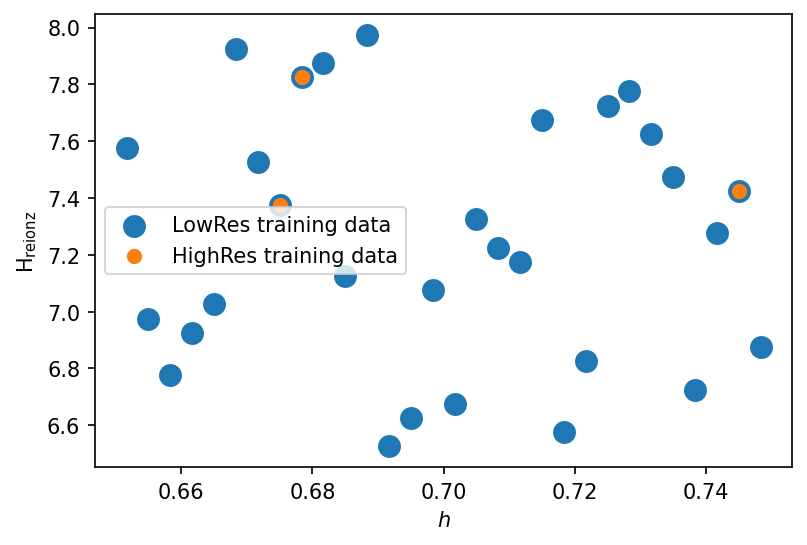

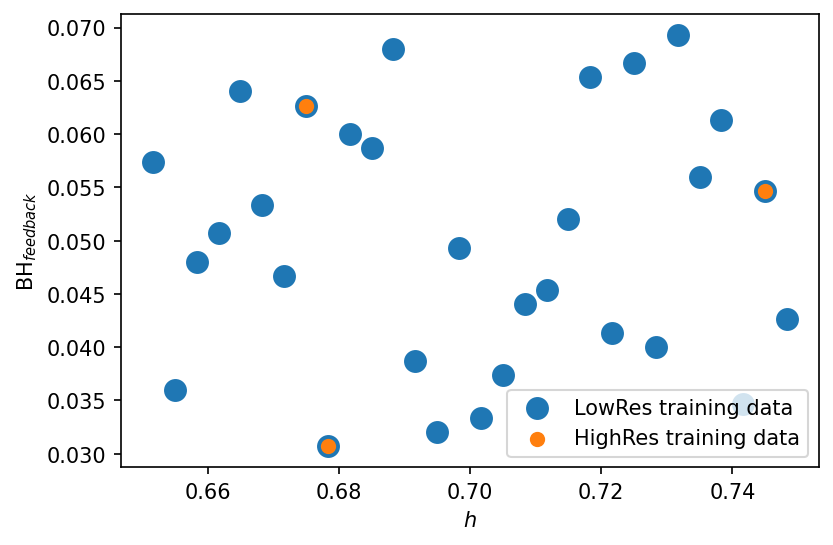

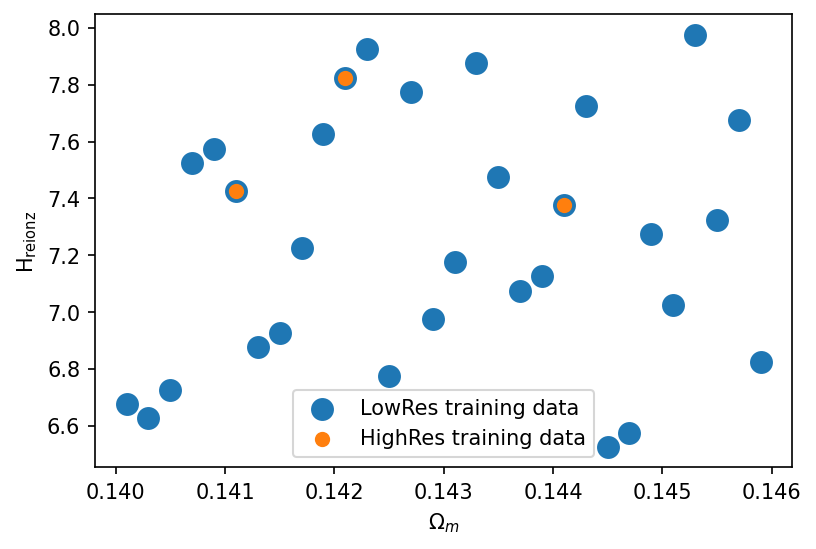

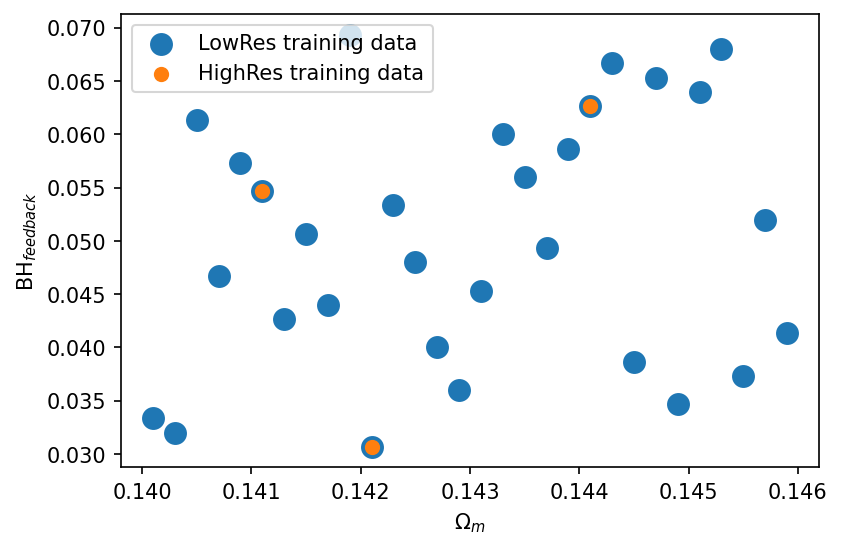

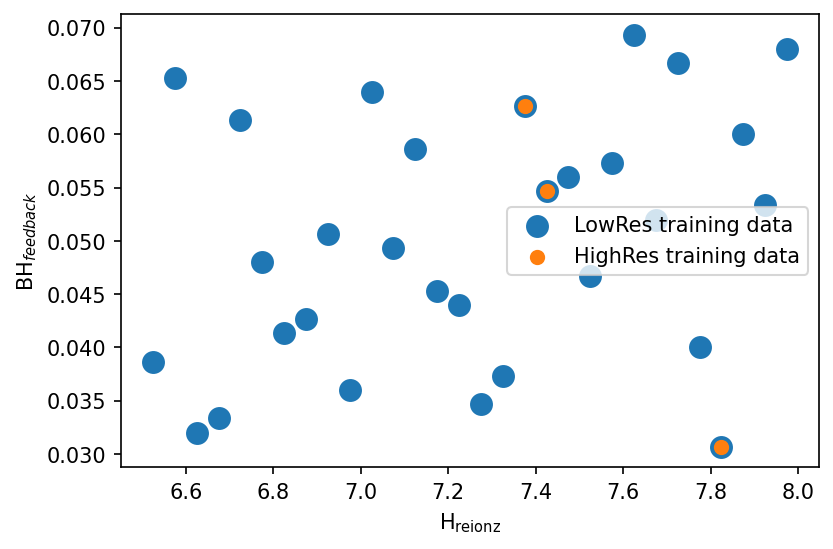

In [13]:
# [individual redshift]
i = 17

print("z = {:.3g}".format(zout[i]))

plot_parameters([X_train, X_train[all_z_next_selected_index[i]]])

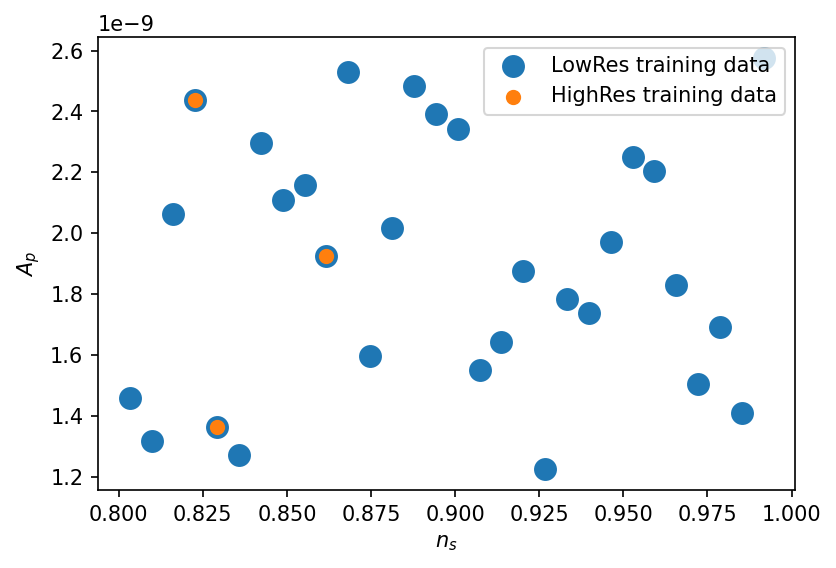

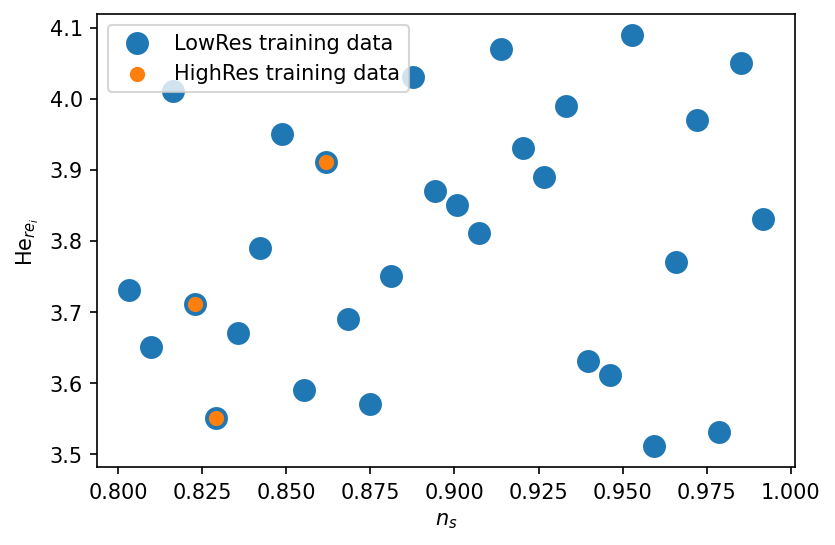

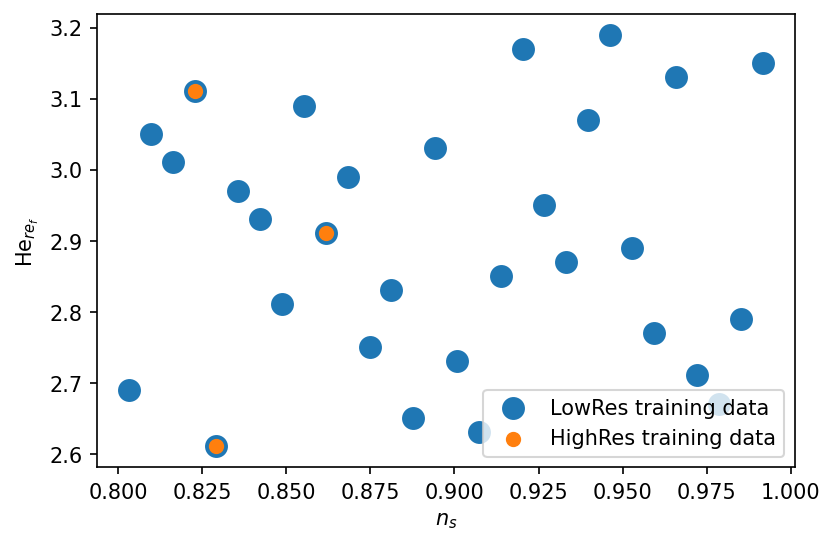

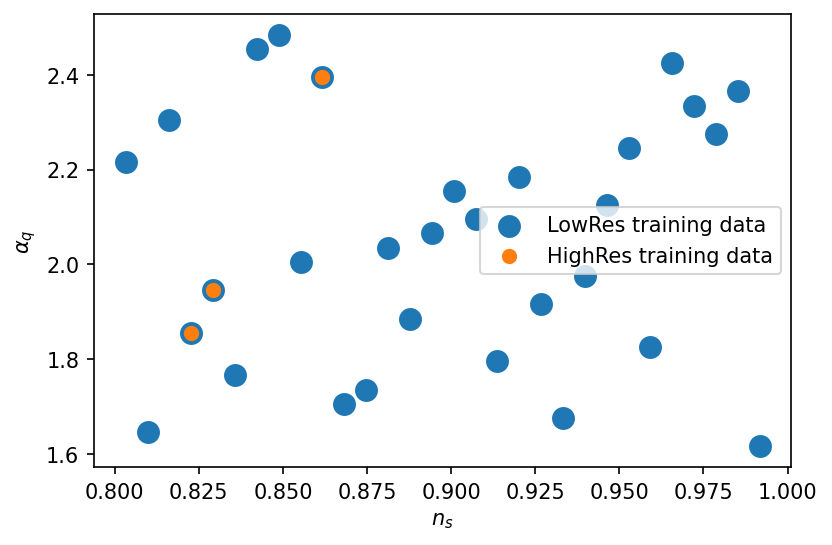

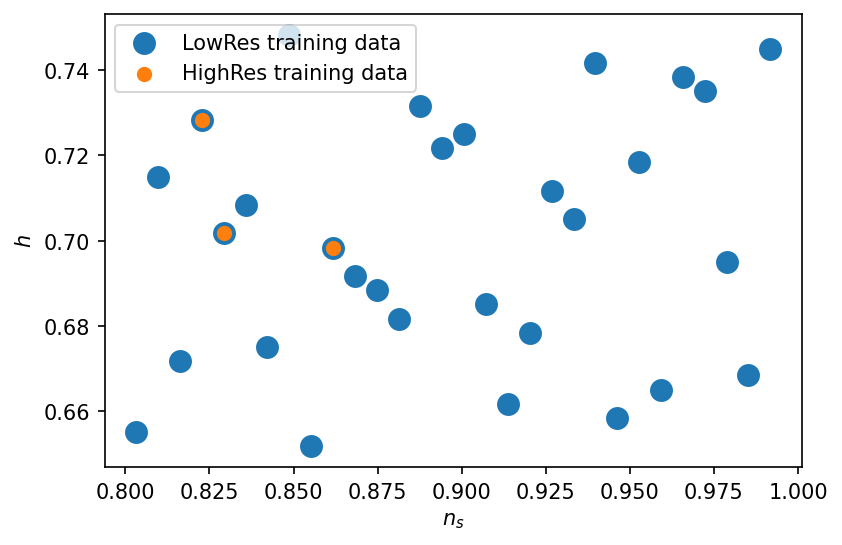

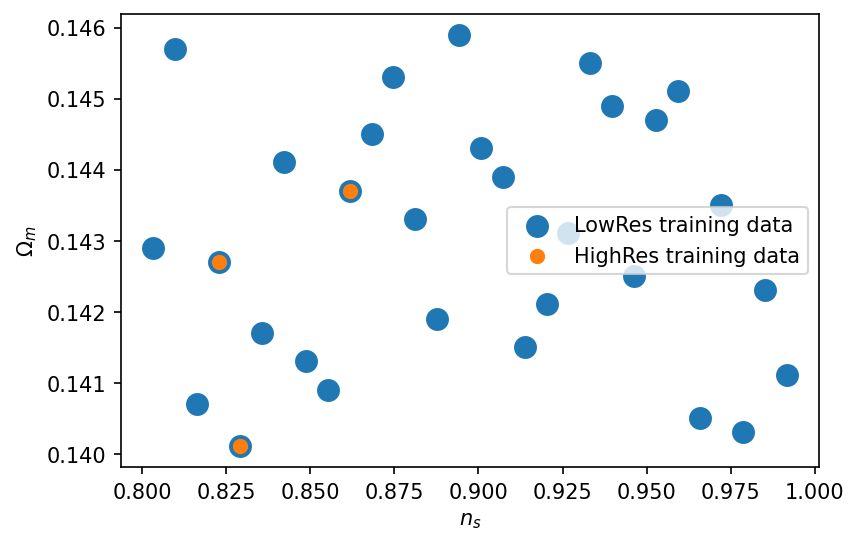

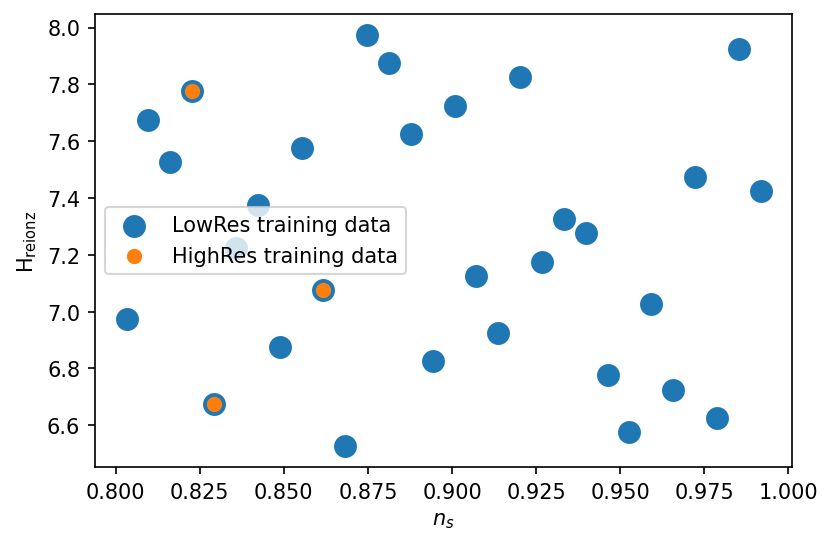

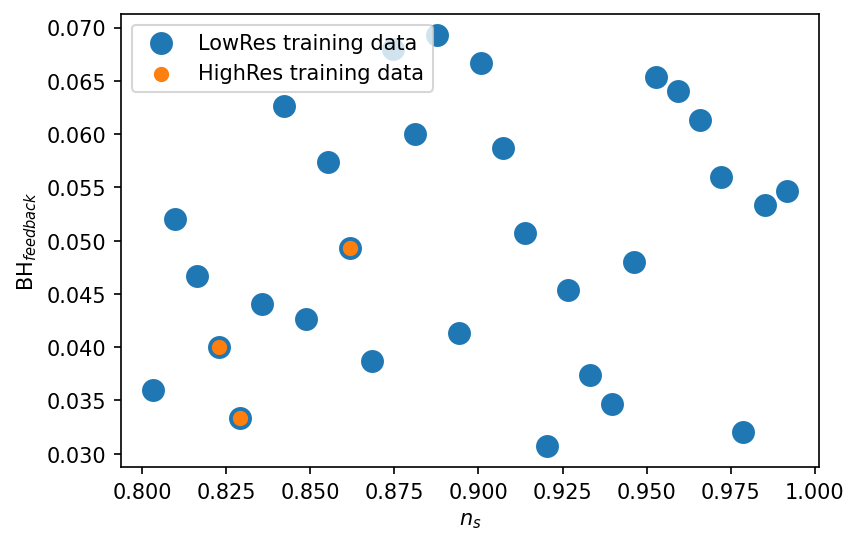

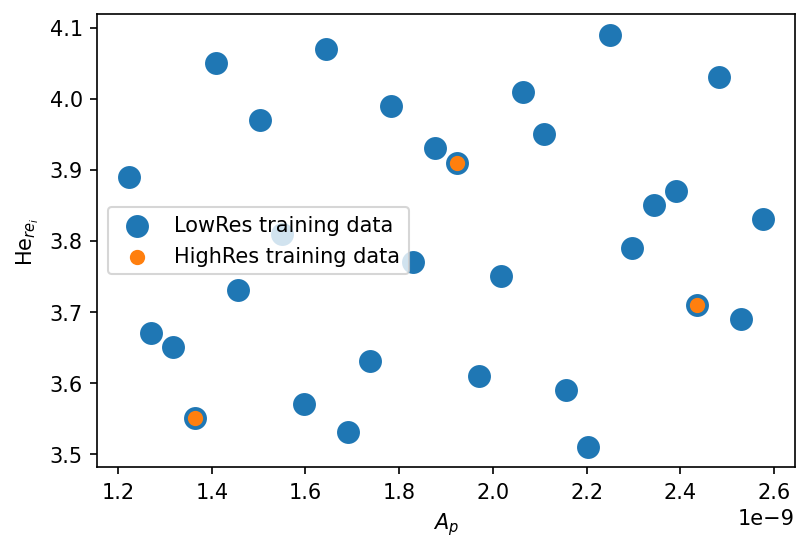

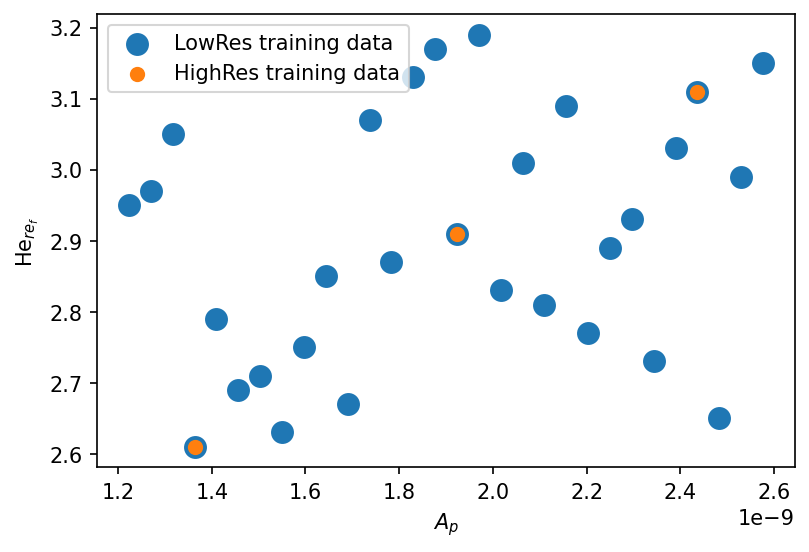

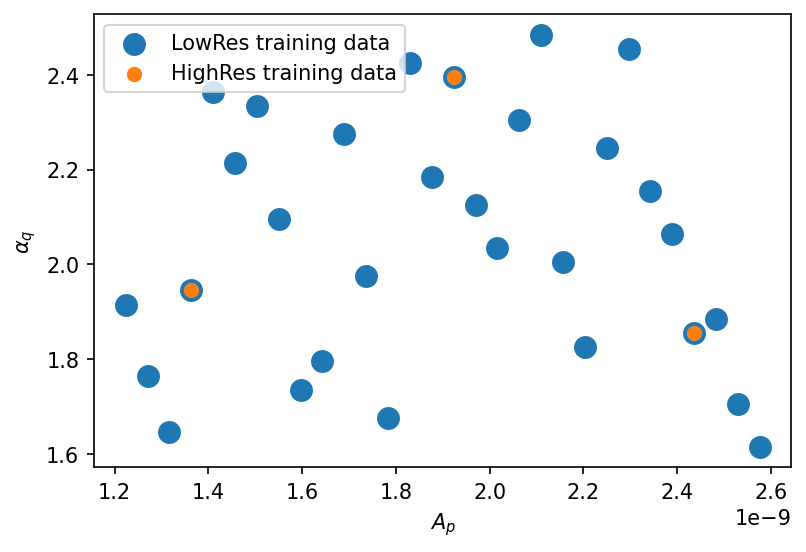

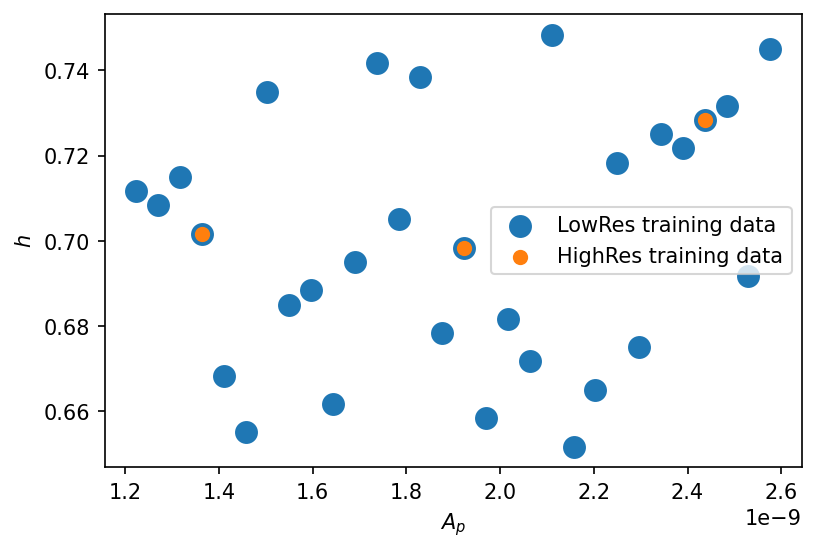

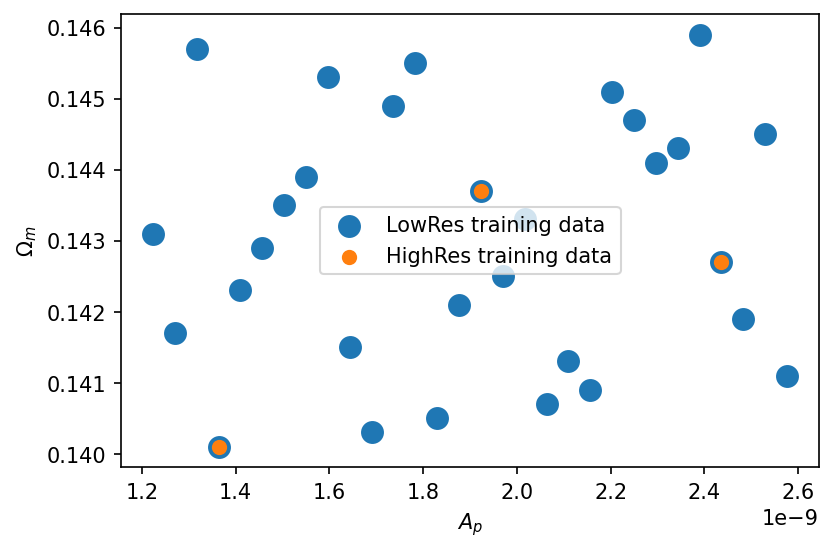

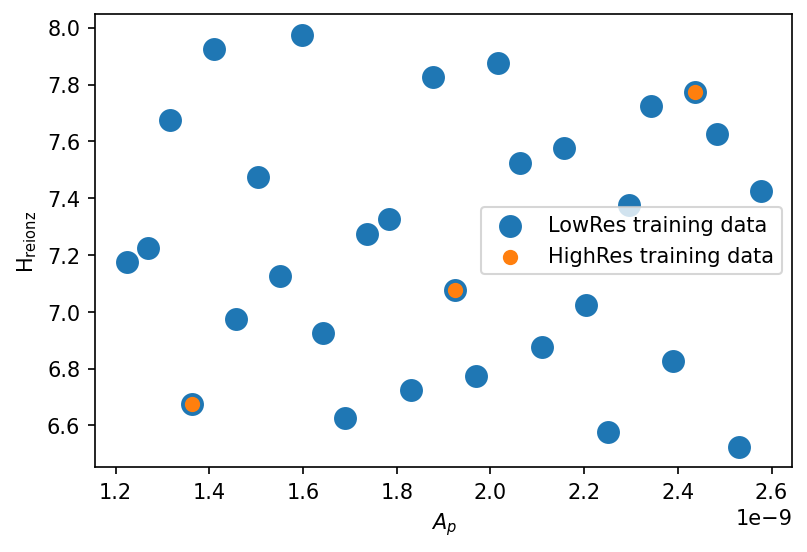

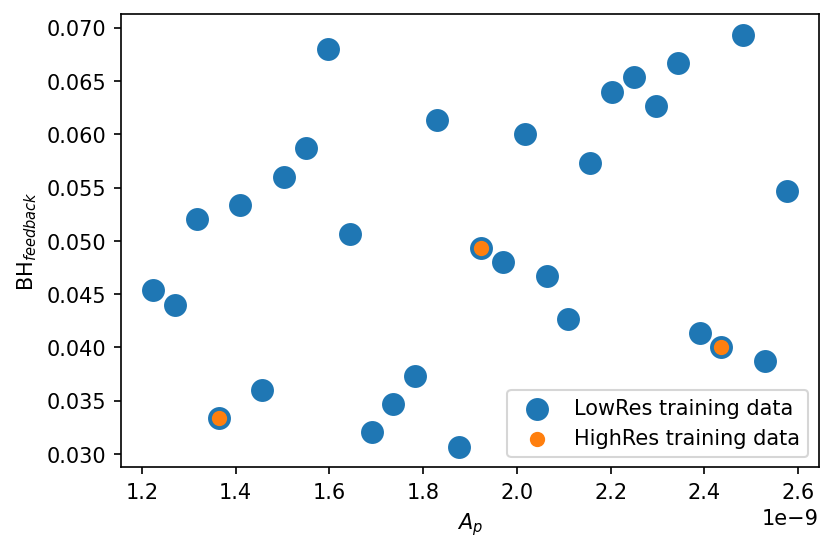

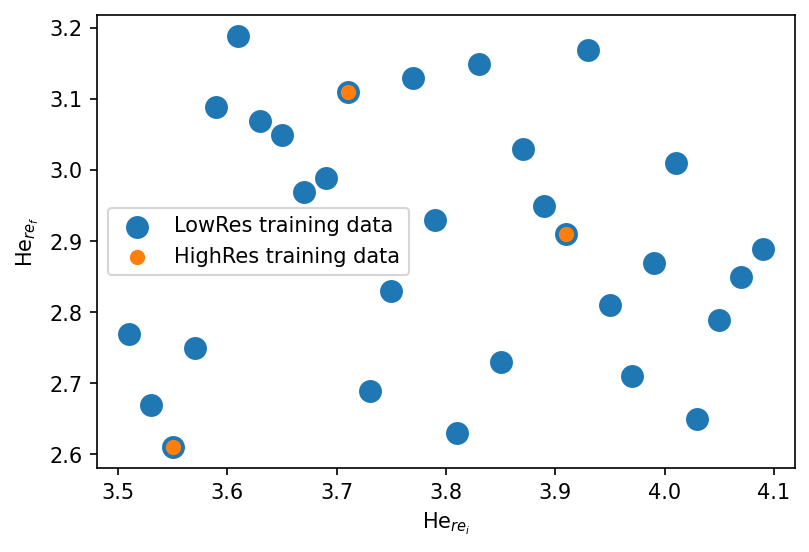

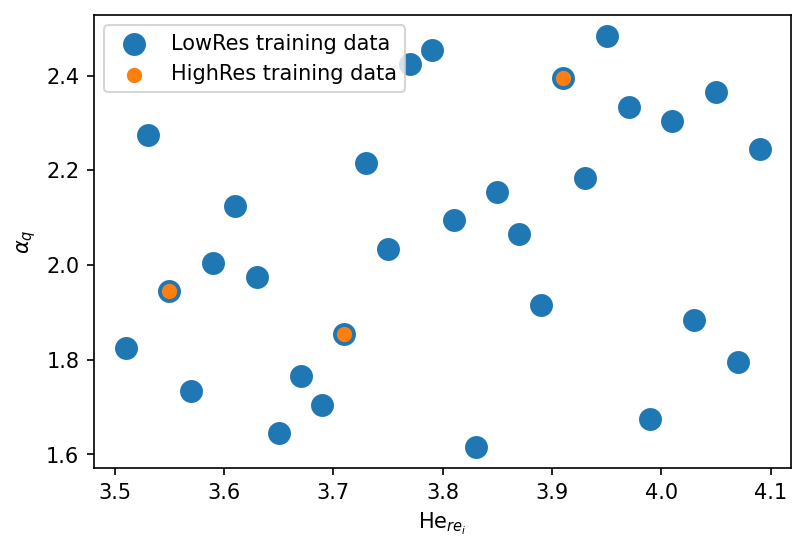

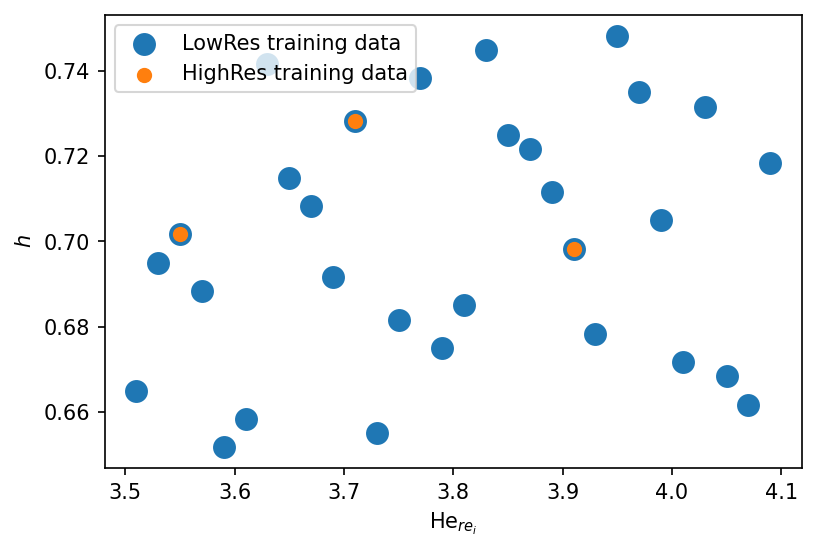

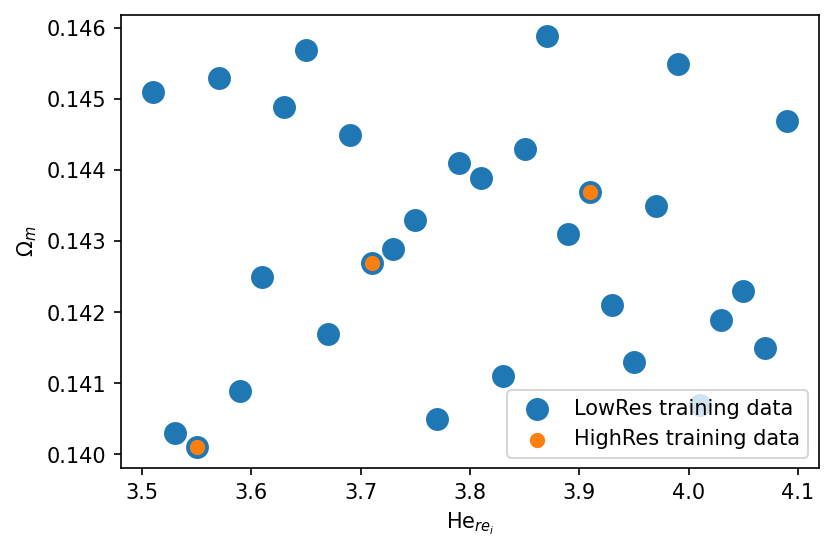

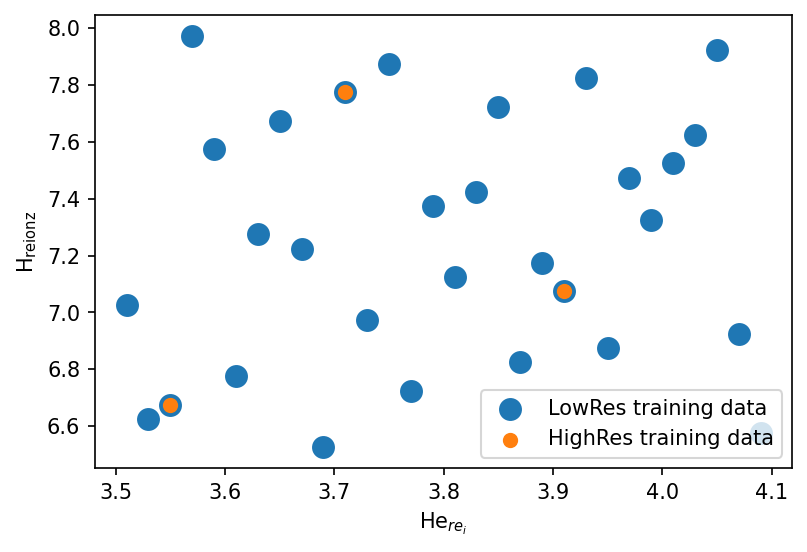

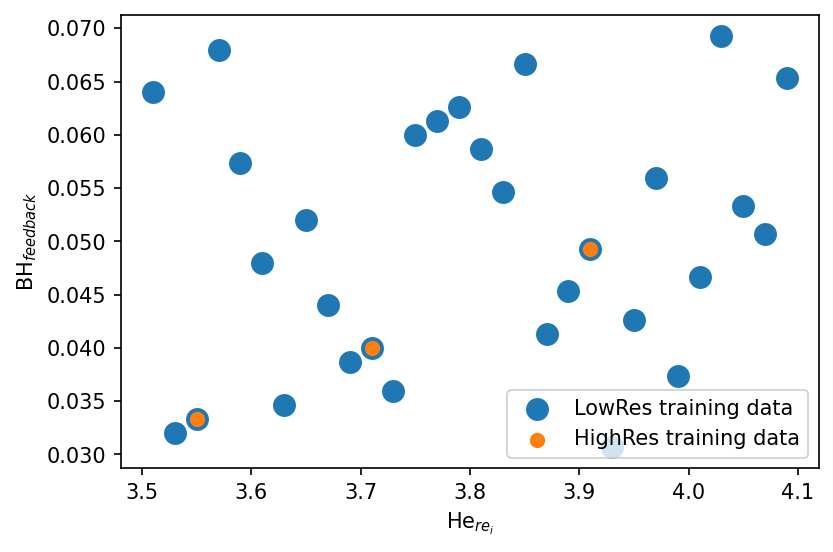

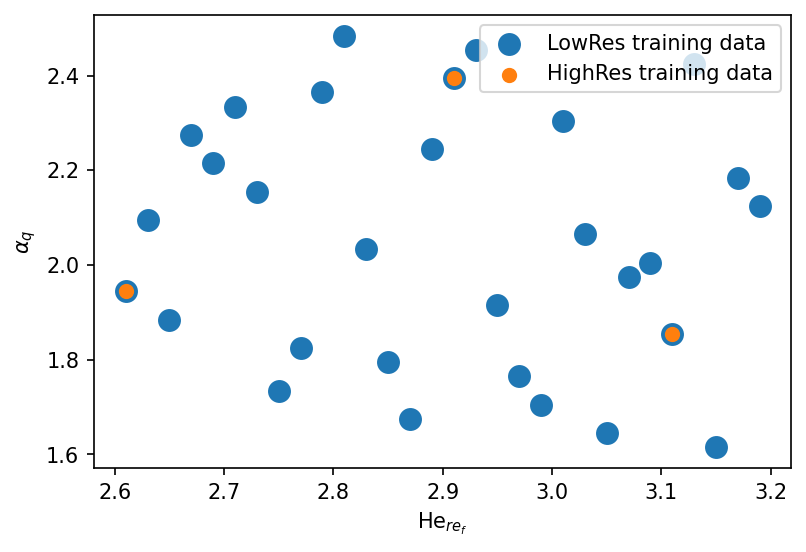

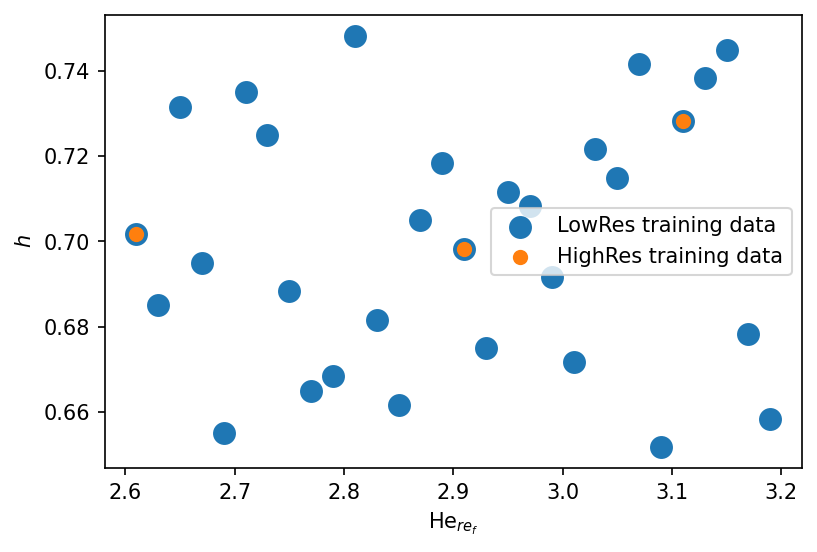

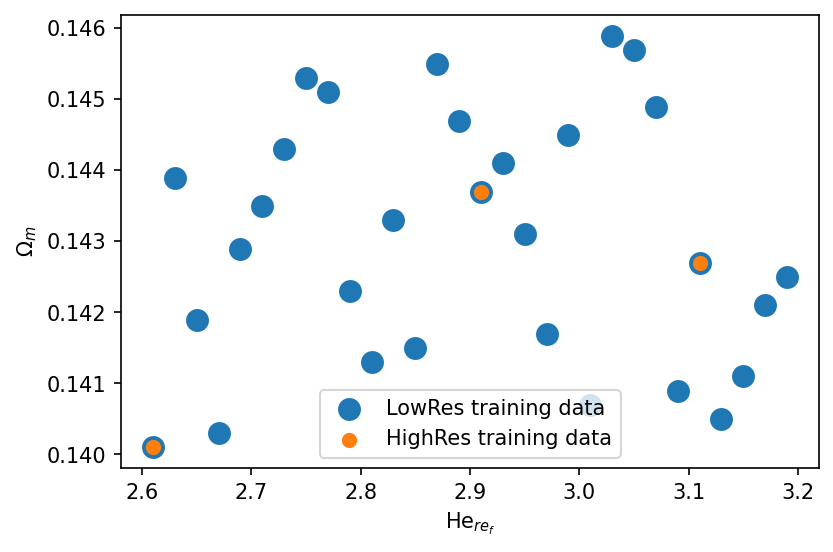

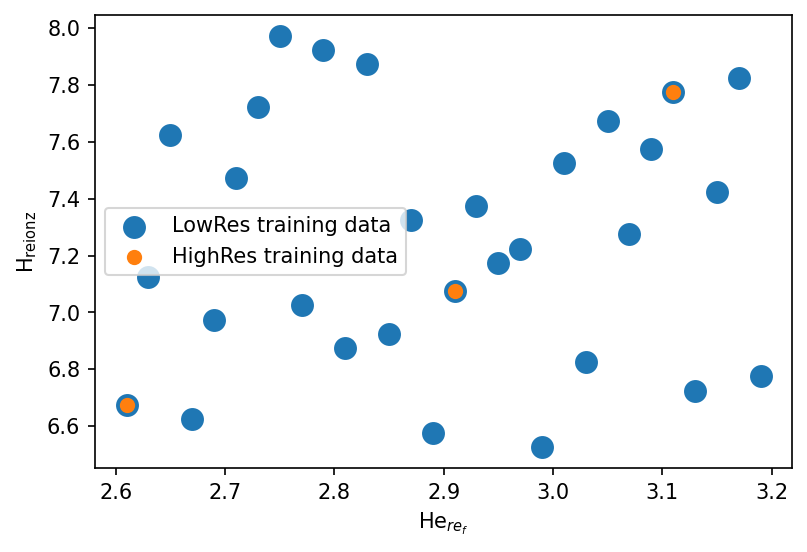

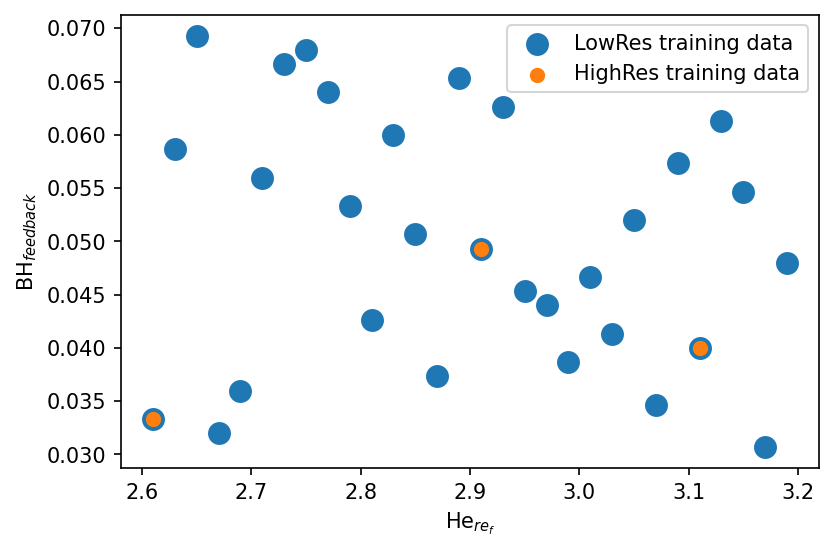

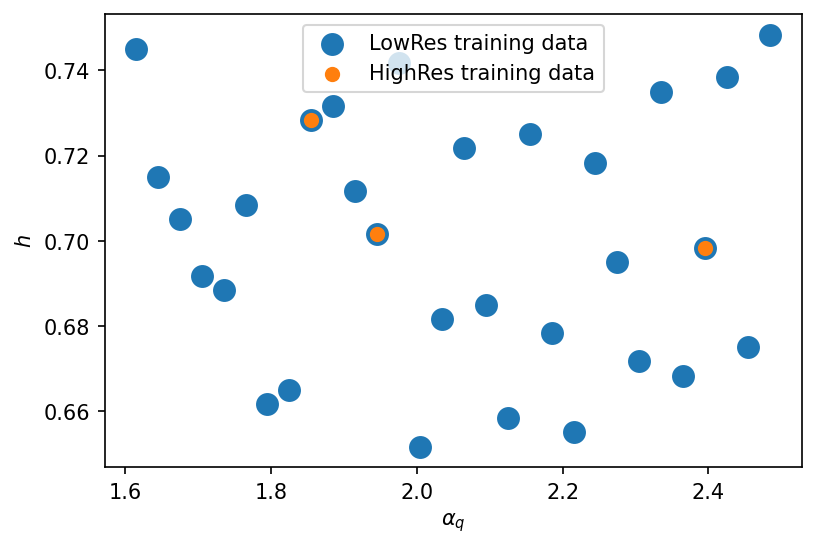

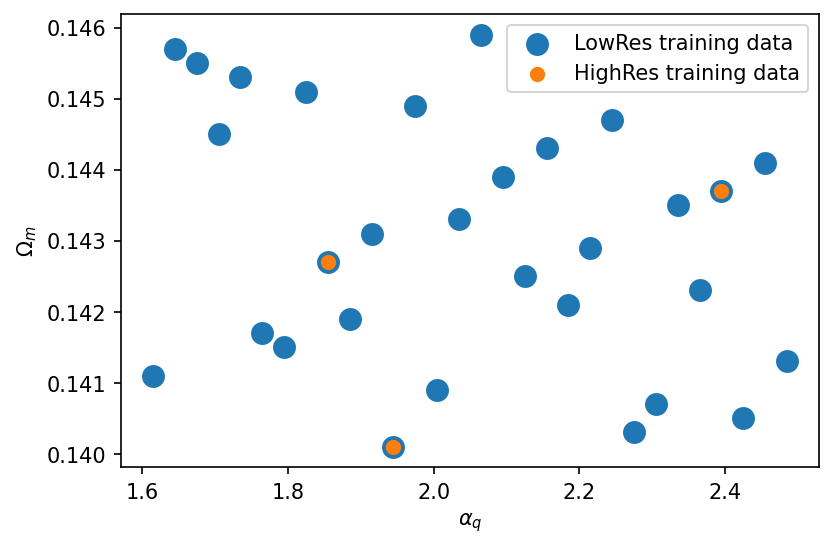

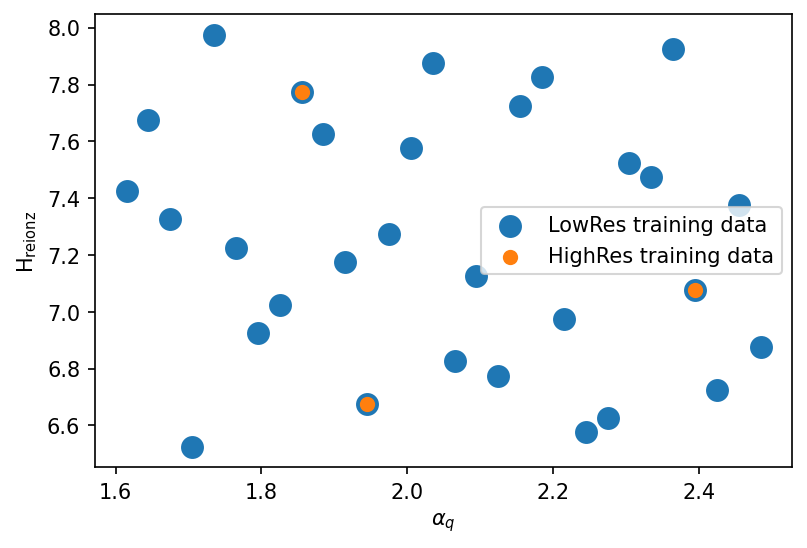

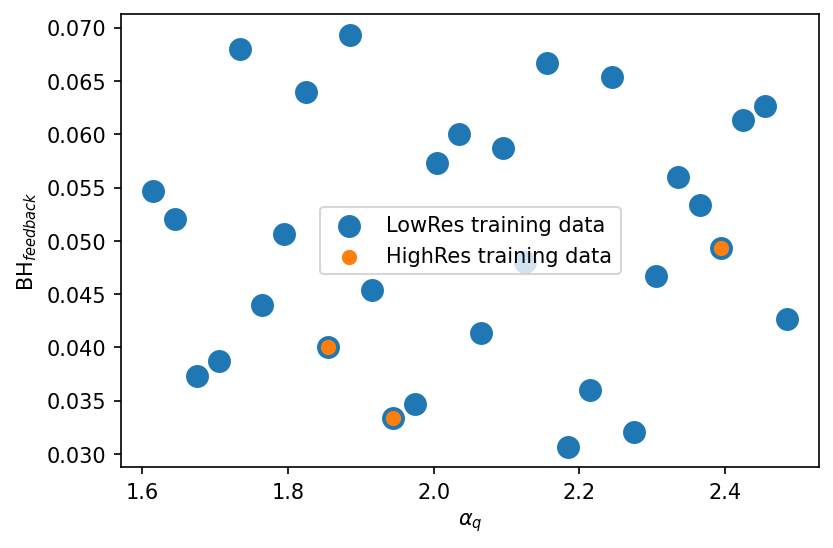

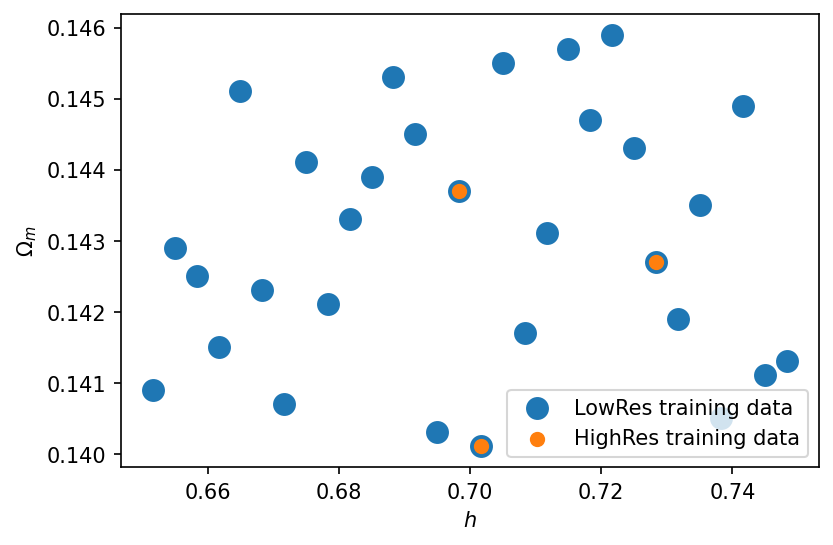

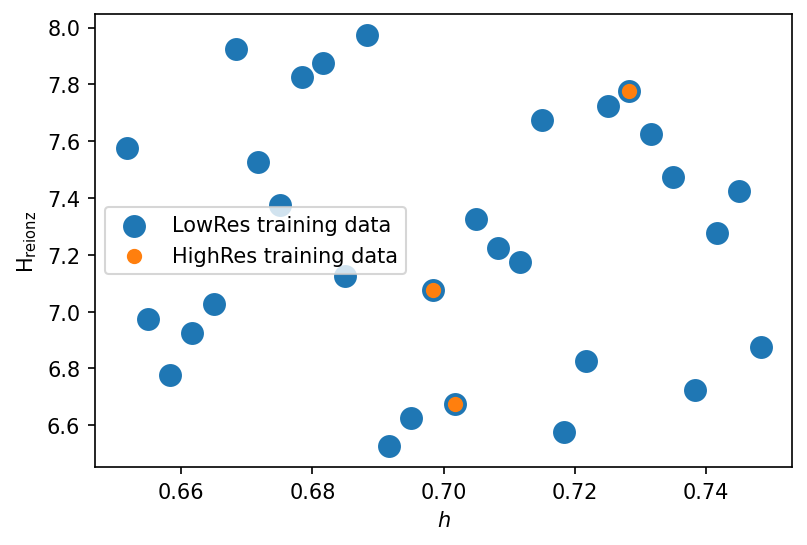

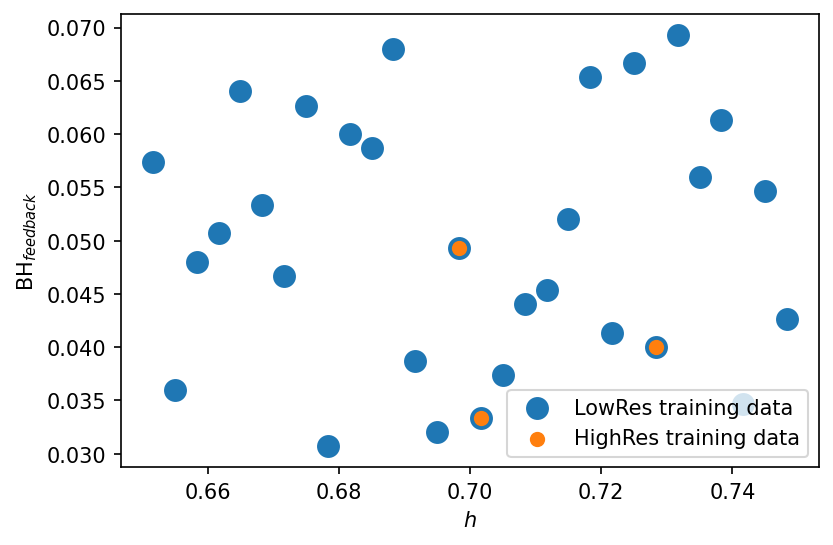

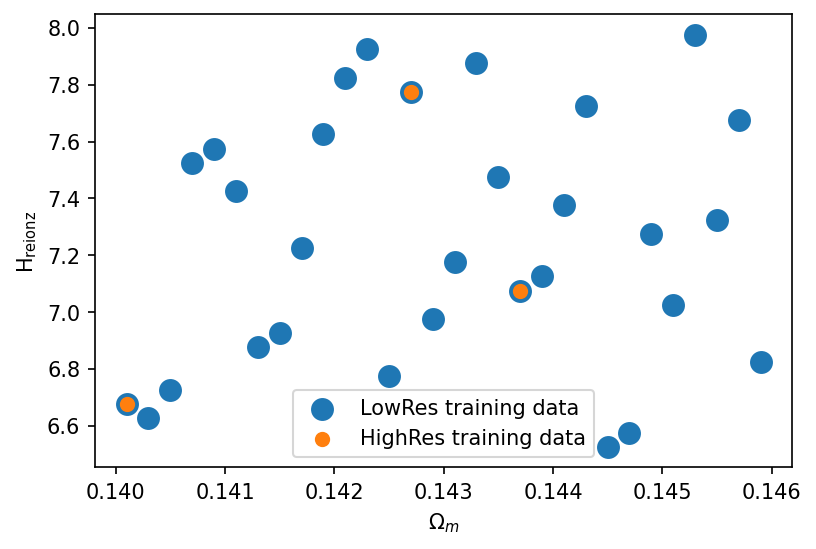

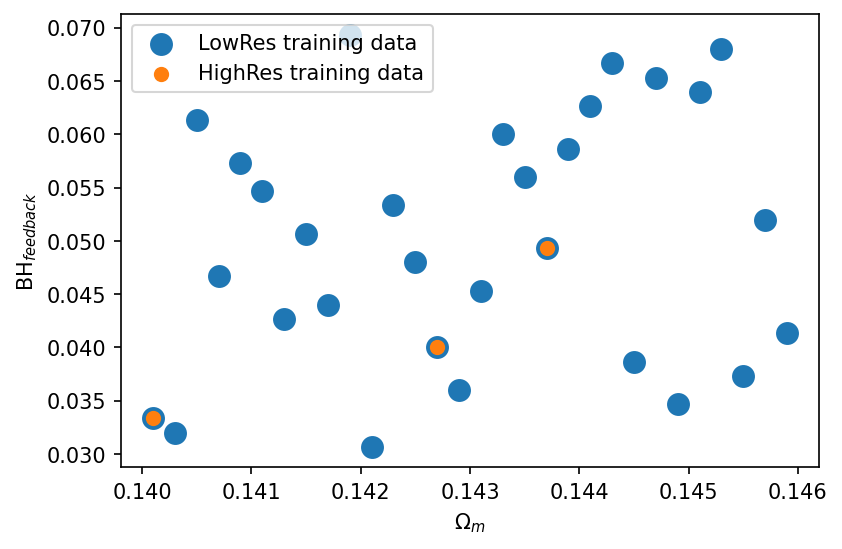

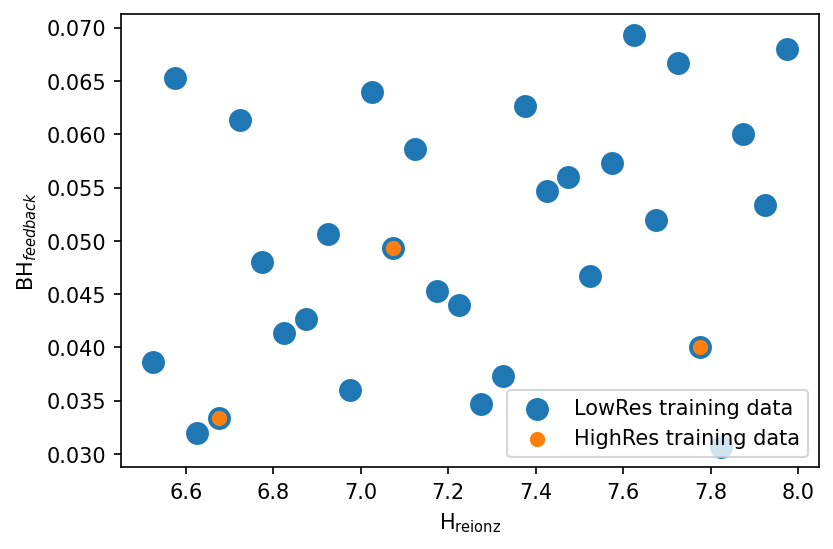

In [14]:
# summing over all redshifts
plot_parameters([X_train, X_train[optimal_index_sum_z]])

## Validate selected two are good enough across different redshifts

In [15]:
# [individual redshifts]
# examining if the z1's selected index also has a low loss at z2
all_loss_index = []
all_loss_combinations = []

for i,z in enumerate(zout):
    
    all_loss = []
    all_index = []

    for selected_index in all_z_selected_index:

        # find the loss of the selected indices (across different redshifts)
        ii = np.where(np.all(all_combinations == selected_index, axis=1))[0][0]
        assert np.all(all_combinations[ii] == selected_index)

        # i : this redshift
        # ii : the index of the selected index from all redshifts
        loss = all_z_loss[i][ii]

        all_loss.append(loss)
        all_index.append(ii)

    all_loss_combinations.append(all_loss)
    all_loss_index.append(all_index)

all_loss_combinations = np.array(all_loss_combinations)
all_loss_index = np.array(all_loss_index)

In [16]:
# [summing over all redshift]
all_loss_index_sum_z = []
all_loss_combinations_sum_z = []

for i,z in enumerate(zout):
    
    # find the loss of the selected indices (across different redshifts)
    ii = np.where(np.all(all_combinations == selected_index_sum_z, axis=1))[0][0]
    assert np.all(all_combinations[ii] == selected_index_sum_z)

    # i : this redshift
    # ii : the index of the selected index from all redshifts
    loss = all_z_loss[i][ii]

    all_loss_combinations_sum_z.append(loss)
    all_loss_index_sum_z.append(ii)

all_loss_combinations_sum_z = np.array(all_loss_combinations_sum_z)
all_loss_index_sum_z = np.array(all_loss_index_sum_z)

Text(0, 0.5, 'MSE at z = 5.4')

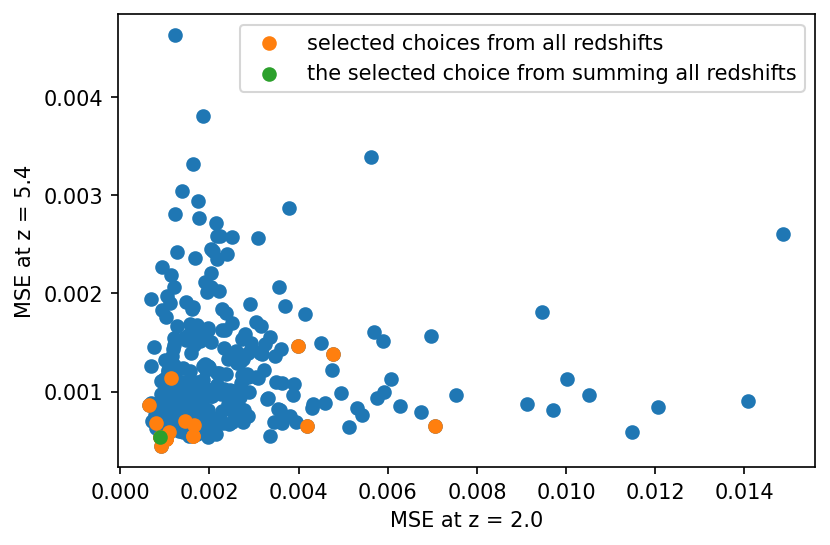

In [17]:
# dims want to be plotted
dim1 = 17
dim2 = 0

# plot two dimensions
plt.scatter(all_z_loss[dim1], all_z_loss[dim2])

# plot the selected ones
plt.scatter(
    np.array(all_z_loss)[dim1][all_loss_index[dim1]],
    np.array(all_z_loss)[dim2][all_loss_index[dim2]],
    label="selected choices from all redshifts"
)
plt.scatter(
    np.array(all_z_loss)[dim1][all_loss_index_sum_z[dim1]],
    np.array(all_z_loss)[dim2][all_loss_index_sum_z[dim2]],
    label="the selected choice from summing all redshifts"
)

plt.legend()
plt.xlabel("MSE at z = {}".format(zout[dim1]))
plt.ylabel("MSE at z = {}".format(zout[dim2]))

## Vaidate the selected three is optimal

Below cells are just for validation. In above cells, we search for optimal two first. And then, condition on the optimal two and search for the 3rd optimal one.

In the below cells, we search for the optimal three directly, which is much more costly to run.

Finally, we verify if the optimal selection we got from above cells also has a low mean squared error compared with searching the optimal three directly.

In [18]:
%%capture
# runs for a very long time on my laptop

# setup parameter settings
param_limits = np.array(param["param_limits"])
X_train = f["params"][()]

# No need to normalize since only single fidelity
# but it's better to map param to a unit cube to avoid
# ARD hyperparameter optimization searching in a wide
# dynamical range
X = input_normalize(X_train, param_limits=param_limits)
print("[Info] Input parameters are normalized to a unit cube.")

# select 3 samples out of 30 samples, use 27 samples to validate
# the GP loss
num_selected = 3

num_samples, _ = X.shape

# looking for all possible combinations
all_3_combinations = list(combinations(range(num_samples), num_selected))

# each z would have len(all_3_combinations) number of loss
all_z_3_loss = []

# loop over all redshifts
for i, z in enumerate(zout):

    # if not log scale, some selections cannot be trained, which might
    # indicate log scale is a better normalization for GP
    Y = np.log10(get_flux_vector_at_z(i))
    print("[Info] Getting flux vector at z = {:.3g} ...".format(z))
    print("[Info] Trun the flux power into log scale.")

    train_opt = TrainSetOptimize(X=X, Y=Y)

    # loop over to get the least loss 2 indices
    # It takes time to loop over all redhifts ...
    all_loss = []

    # loop over all possible three selections
    for j,selected_index in enumerate(all_3_combinations):

        # need to convert to boolean array
        ind = np.zeros(num_samples, dtype=np.bool)
        ind[np.array(selected_index)] = True

        # MSE loss
        loss = train_opt.loss(ind)

        print("iteration: {} out of {}".format((i, j), (len(zout), len(all_combinations))))

        all_loss.append(loss)
    
    all_z_3_loss.append(all_loss)

In [19]:
# find the set of 3 indices best minimize the loss

# [sum over all redshifts]
all_sum_z_3_loss = np.array(all_z_3_loss).sum(axis=0)

all_z_3_selected_index = []

# need to print for all redshifts
for i,z in enumerate(zout):

    all_loss = all_z_3_loss[i]

    selected_index = np.array(all_3_combinations[np.argmin(all_loss)])

    print("Optimal three ({:2d}, {:2d}, {:2d}) for z = {:.3g}".format(
        selected_index[0], selected_index[1], selected_index[2], z))

    all_z_3_selected_index.append(selected_index)

# [sum over all redshifts]
selected_index_sum_z_3 = np.array(all_3_combinations[np.argmin(all_sum_z_3_loss)])
print("Optimal three (summing over all redshifts) ({:2d}, {:2d}, {:2d}).".format(
    selected_index_sum_z_3[0], selected_index_sum_z_3[1], selected_index_sum_z_3[2]))

Optimal three (10, 25, 29) for z = 5.4
Optimal three ( 3,  4, 11) for z = 5.2
Optimal three ( 1, 23, 26) for z = 5
Optimal three (10, 25, 29) for z = 4.8
Optimal three ( 7, 22, 26) for z = 4.6
Optimal three (10, 25, 29) for z = 4.4
Optimal three ( 6, 12, 18) for z = 4.2
Optimal three ( 6, 12, 18) for z = 4
Optimal three ( 1, 12, 18) for z = 3.8
Optimal three ( 0, 23, 24) for z = 3.6
Optimal three ( 7, 10, 26) for z = 3.4
Optimal three ( 2,  6, 24) for z = 3.2
Optimal three ( 2, 24, 27) for z = 3
Optimal three (12, 24, 25) for z = 2.8
Optimal three ( 8, 24, 28) for z = 2.6
Optimal three ( 8, 24, 28) for z = 2.4
Optimal three ( 7, 11, 18) for z = 2.2
Optimal three ( 7, 11, 18) for z = 2
Optimal three (summing over all redshifts) ( 1, 17, 18).


In [20]:
# what's the index of our optimal selection
idx = np.where(np.all(np.array(all_3_combinations) == np.sort(optimal_index_sum_z), axis=1))[0][0]

for i,z_3_loss in enumerate(all_z_3_loss):
    # how many selections have larger loss than our optimal one?
    better_than = np.sum(z_3_loss[idx] < np.array(z_3_loss)) / len(z_3_loss)
    print("Better than {:.3g} of the selections at z = {:.2g}".format(better_than, zout[i]))

# compared with running all three combinations
better_than = np.sum(all_sum_z_3_loss[idx] < np.array(all_sum_z_3_loss)) / len(all_sum_z_3_loss)
print("Better than {:.3g} of the selections (summing over all redshifts)".format(better_than))

Better than 0.383 of the selections at z = 5.4
Better than 0.508 of the selections at z = 5.2
Better than 0.499 of the selections at z = 5
Better than 0.547 of the selections at z = 4.8
Better than 0.59 of the selections at z = 4.6
Better than 0.639 of the selections at z = 4.4
Better than 0.796 of the selections at z = 4.2
Better than 0.733 of the selections at z = 4
Better than 0.966 of the selections at z = 3.8
Better than 0.894 of the selections at z = 3.6
Better than 0.983 of the selections at z = 3.4
Better than 0.981 of the selections at z = 3.2
Better than 0.982 of the selections at z = 3
Better than 0.988 of the selections at z = 2.8
Better than 0.98 of the selections at z = 2.6
Better than 0.878 of the selections at z = 2.4
Better than 0.941 of the selections at z = 2.2
Better than 0.966 of the selections at z = 2
Better than 0.952 of the selections (summing over all redshifts)


If we use the selection directed chosen from all combinations of three:

In [21]:
# what's the index of our optimal selection
idx = np.where(np.all(np.array(all_3_combinations) == np.sort(selected_index_sum_z_3), axis=1))[0][0]

for i,z_3_loss in enumerate(all_z_3_loss):
    # how many selections have larger loss than our optimal one?
    better_than = np.sum(z_3_loss[idx] < np.array(z_3_loss)) / len(z_3_loss)
    print("Better than {:.3g} of the selections at z = {:.2g}".format(better_than, zout[i]))

# compared with running all three combinations
better_than = np.sum(all_sum_z_3_loss[idx] < np.array(all_sum_z_3_loss)) / len(all_sum_z_3_loss)
print("Better than {:.3g} of the selections (summing over all redshifts)".format(better_than))

Better than 0.993 of the selections at z = 5.4
Better than 0.996 of the selections at z = 5.2
Better than 0.997 of the selections at z = 5
Better than 0.998 of the selections at z = 4.8
Better than 0.998 of the selections at z = 4.6
Better than 0.998 of the selections at z = 4.4
Better than 0.999 of the selections at z = 4.2
Better than 0.999 of the selections at z = 4
Better than 0.999 of the selections at z = 3.8
Better than 0.996 of the selections at z = 3.6
Better than 0.999 of the selections at z = 3.4
Better than 1 of the selections at z = 3.2
Better than 0.999 of the selections at z = 3
Better than 0.997 of the selections at z = 2.8
Better than 0.994 of the selections at z = 2.6
Better than 0.993 of the selections at z = 2.4
Better than 0.933 of the selections at z = 2.2
Better than 0.836 of the selections at z = 2
Better than 1 of the selections (summing over all redshifts)


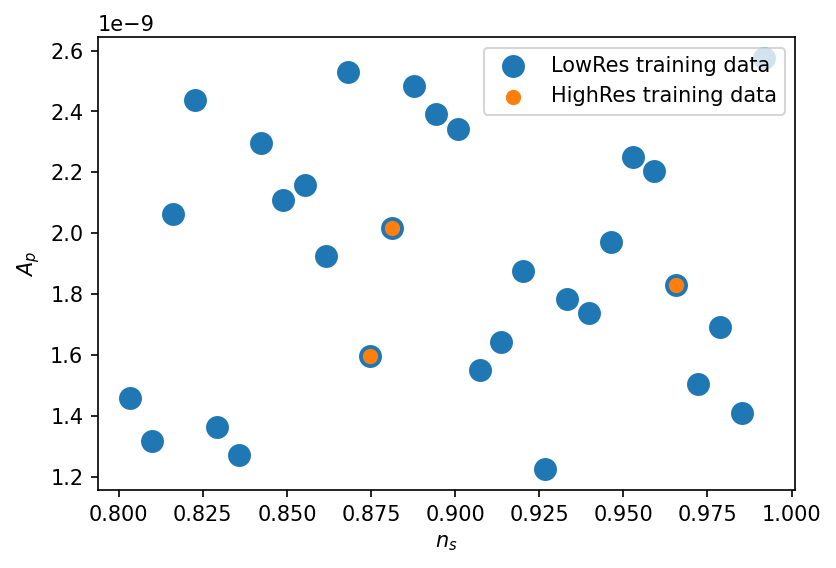

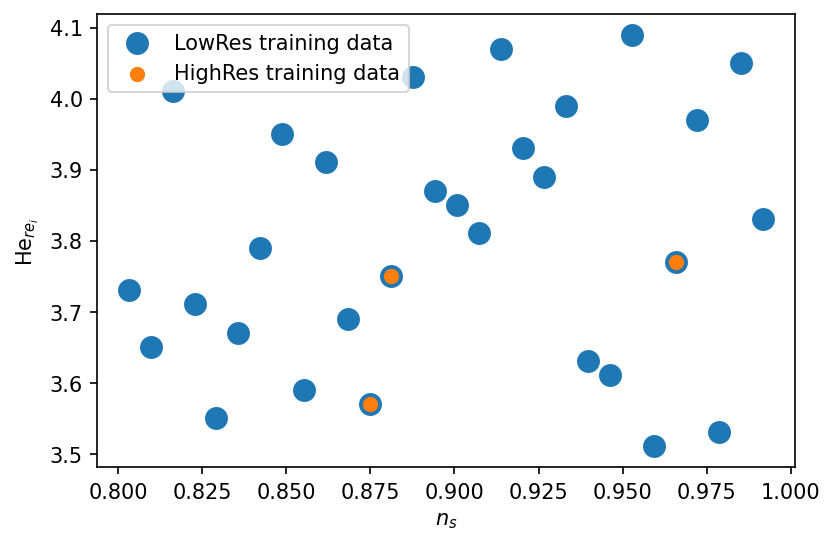

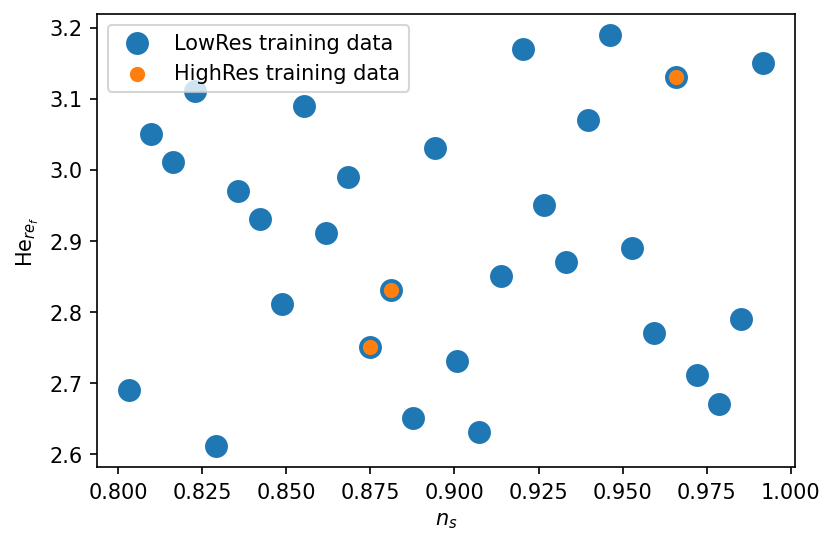

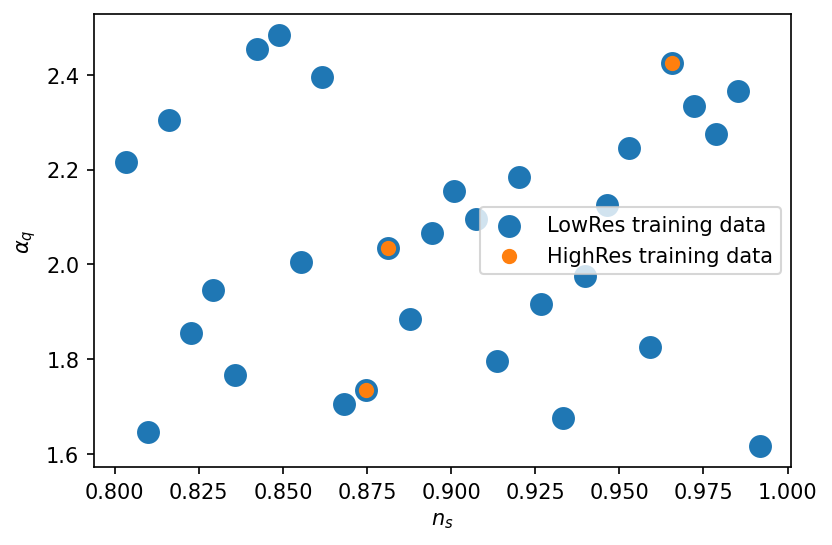

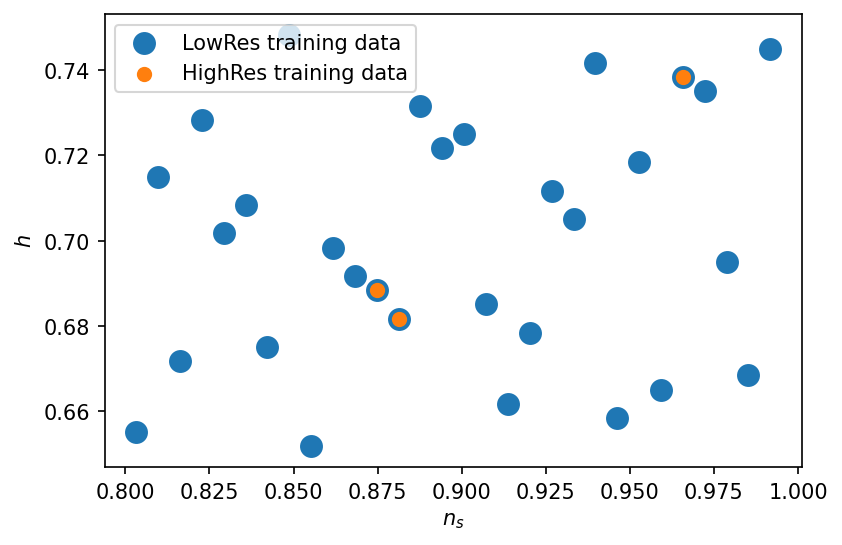

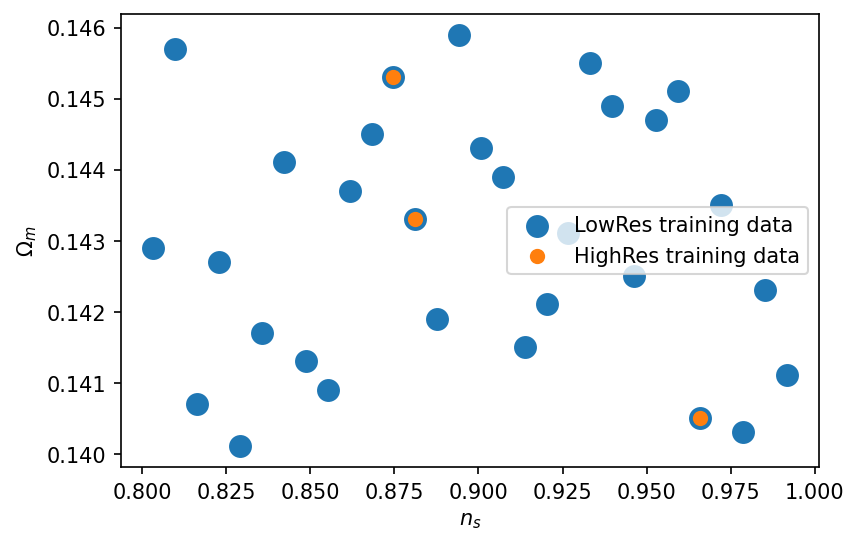

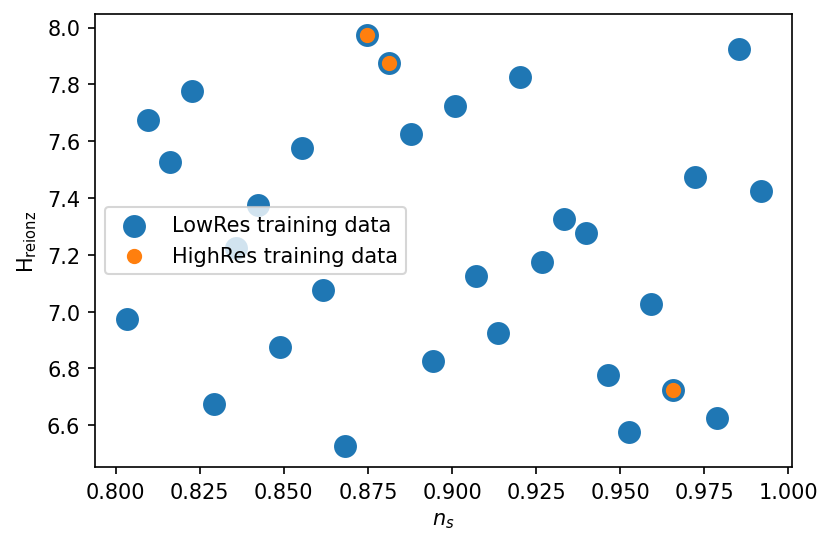

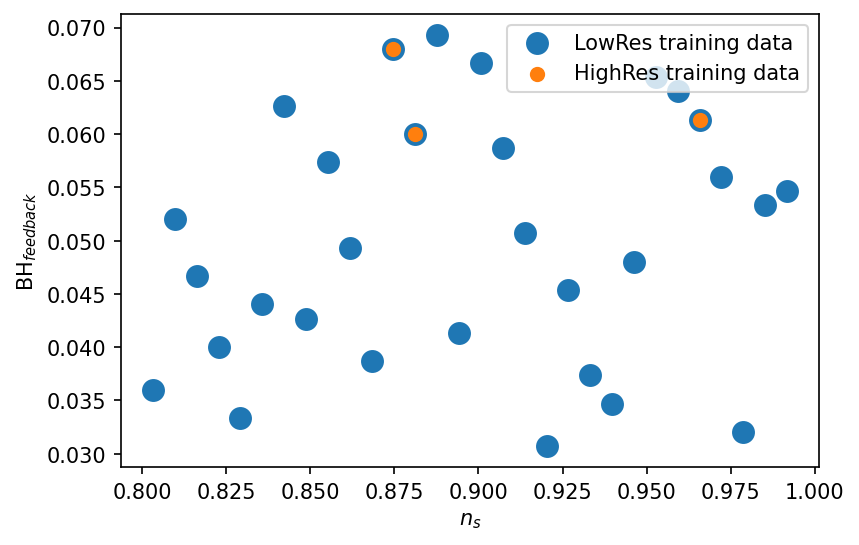

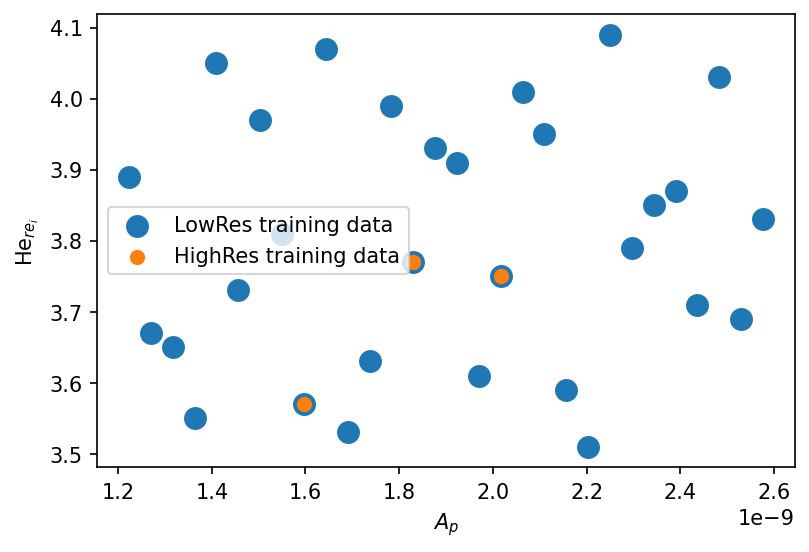

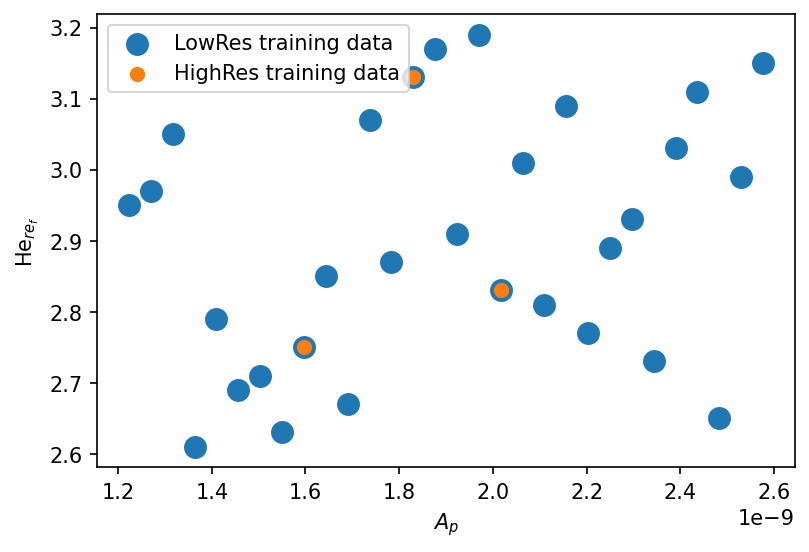

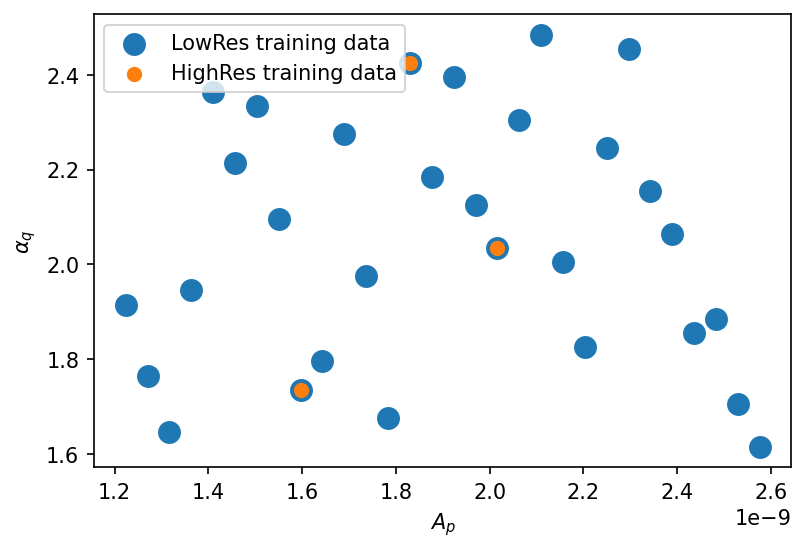

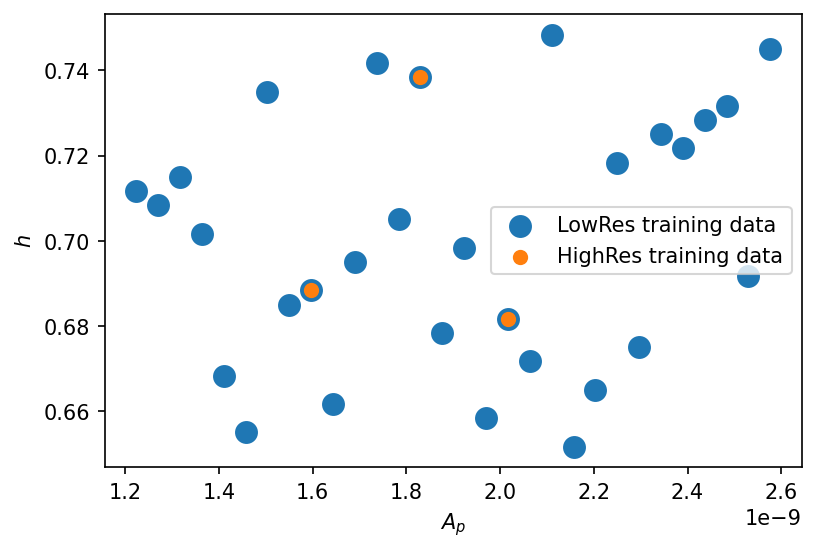

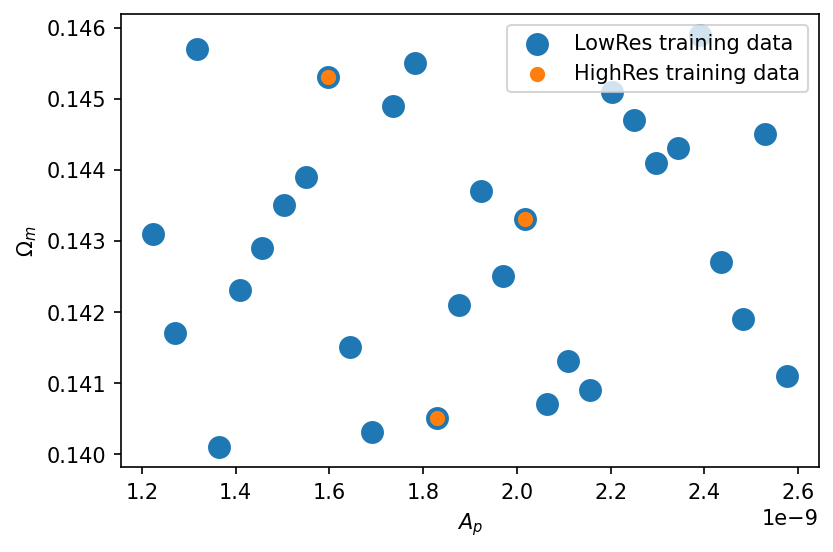

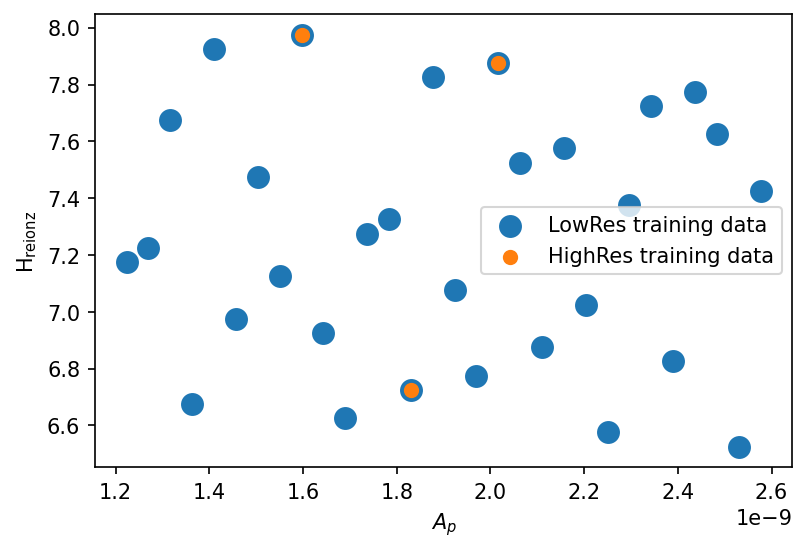

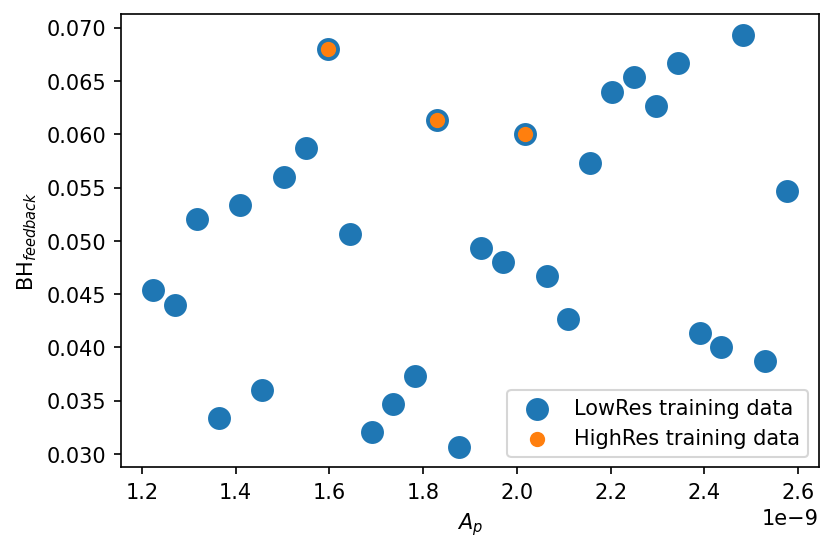

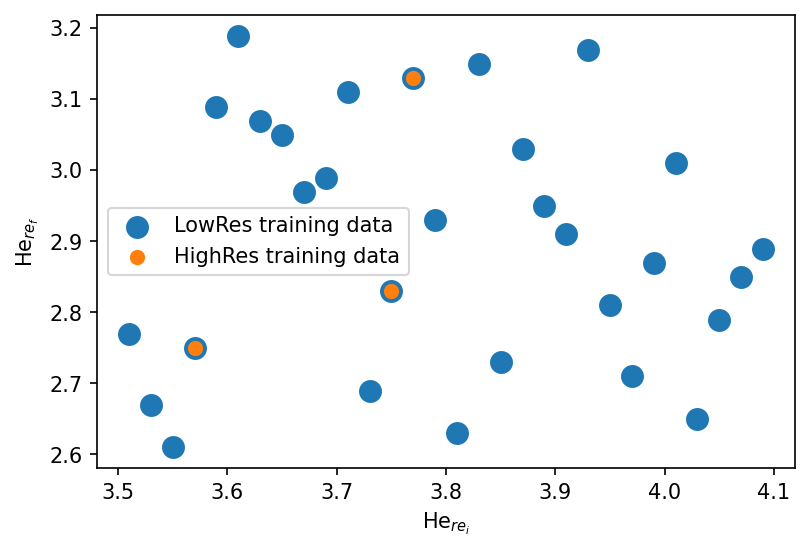

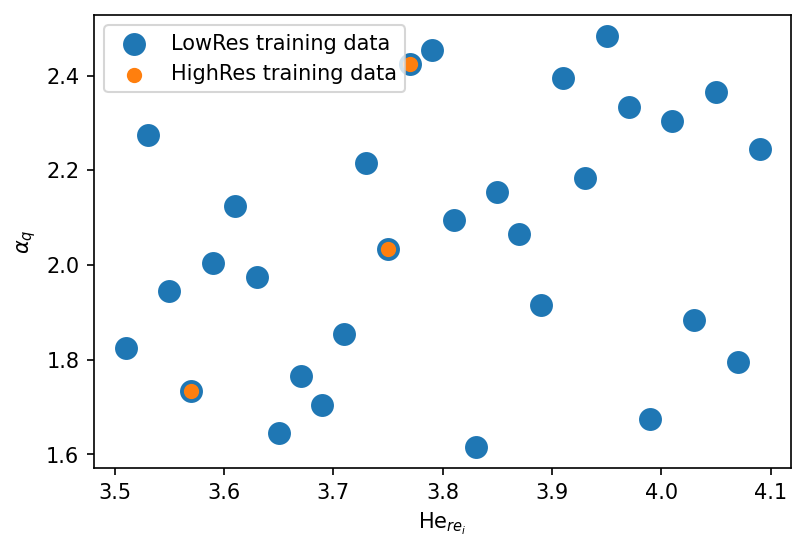

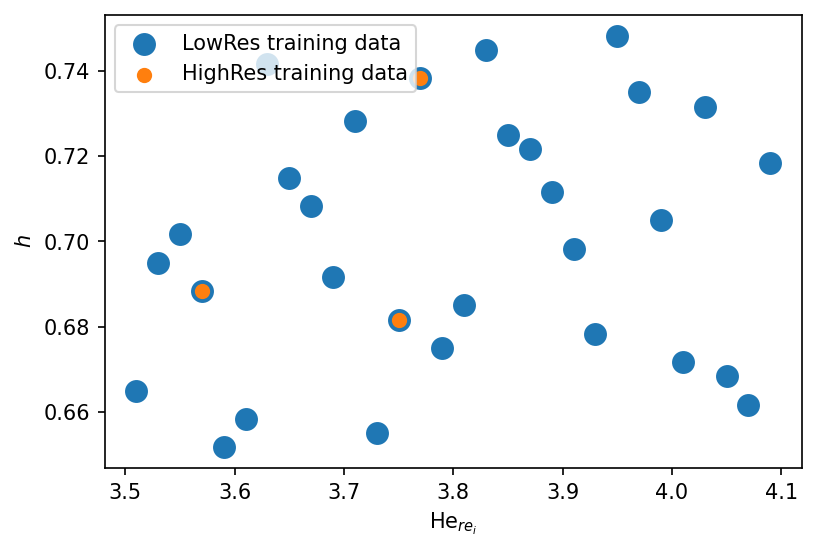

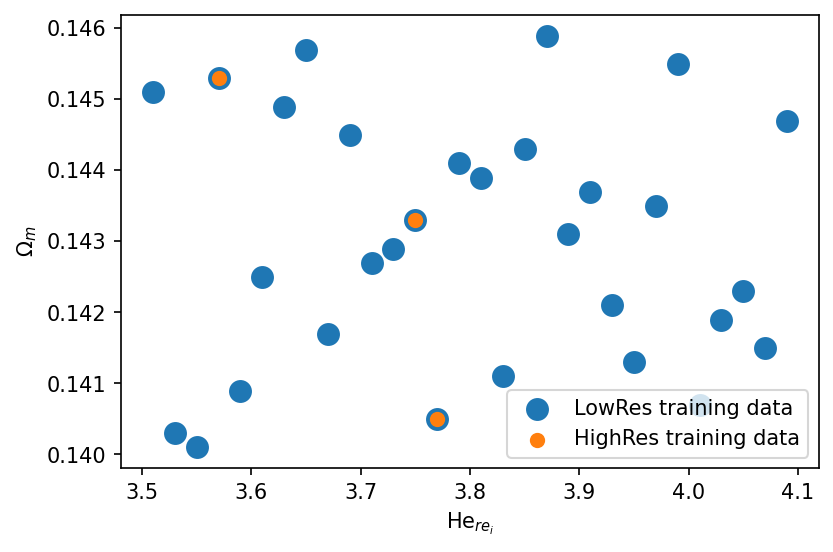

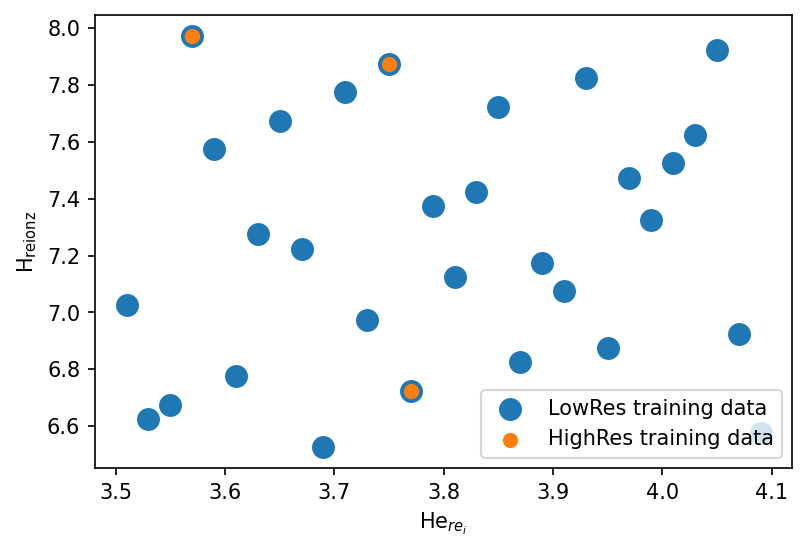

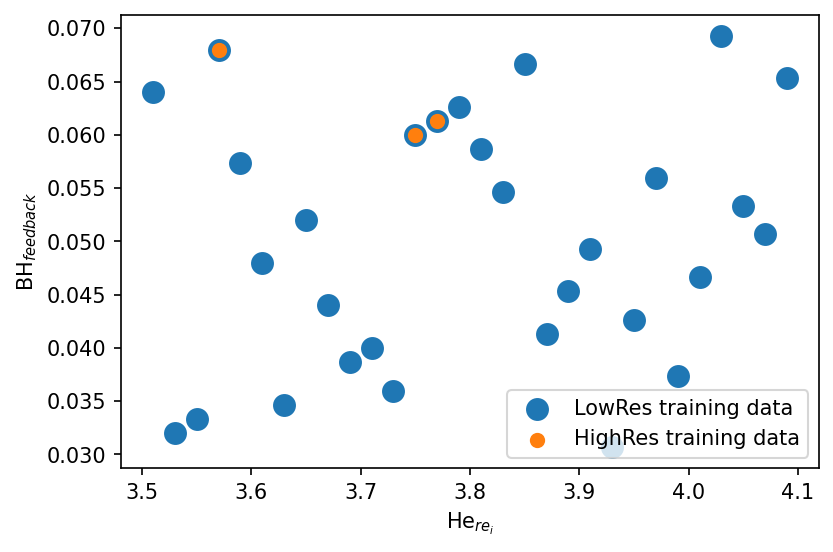

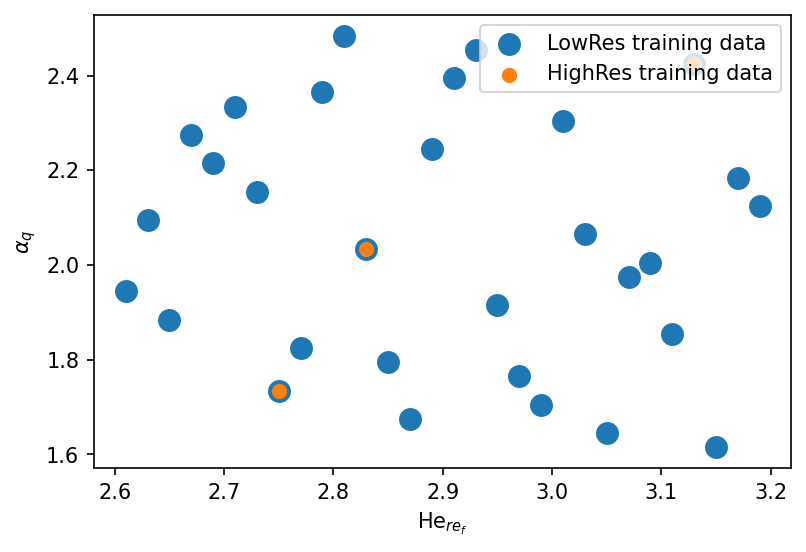

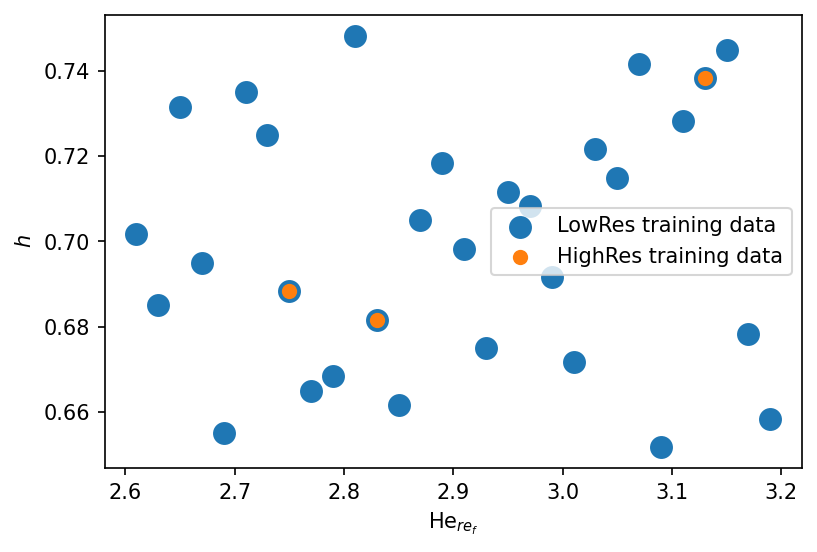

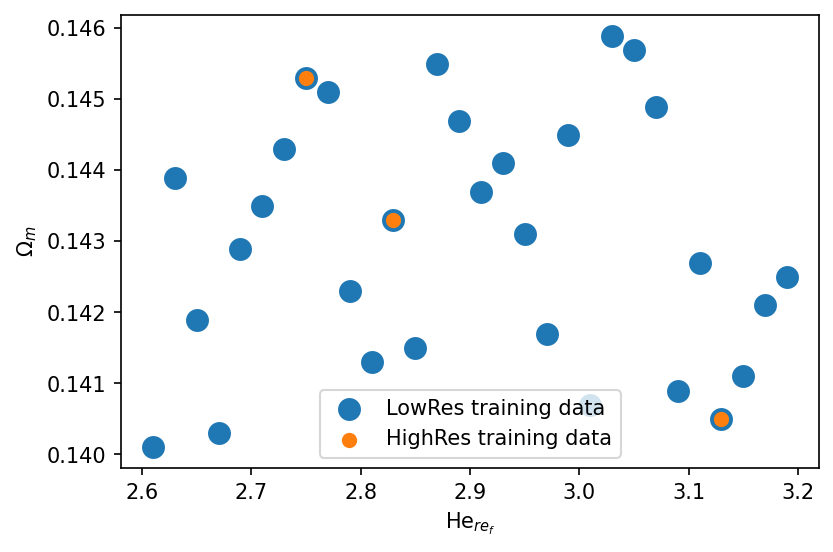

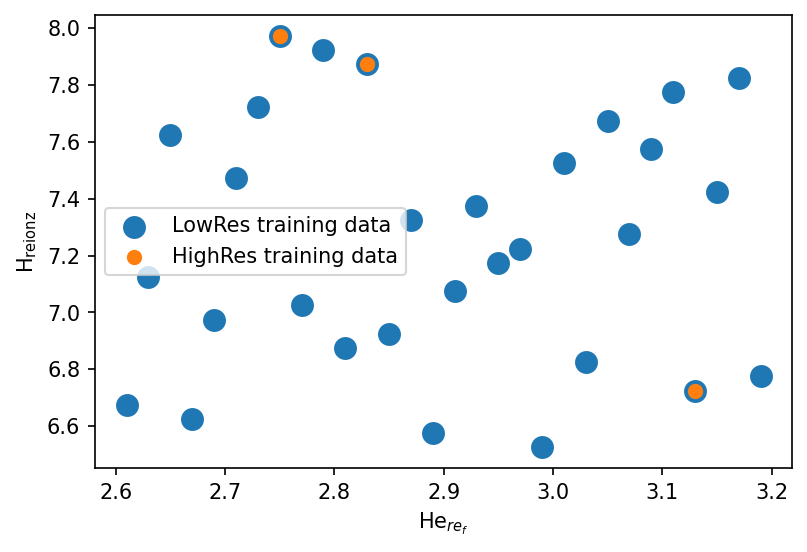

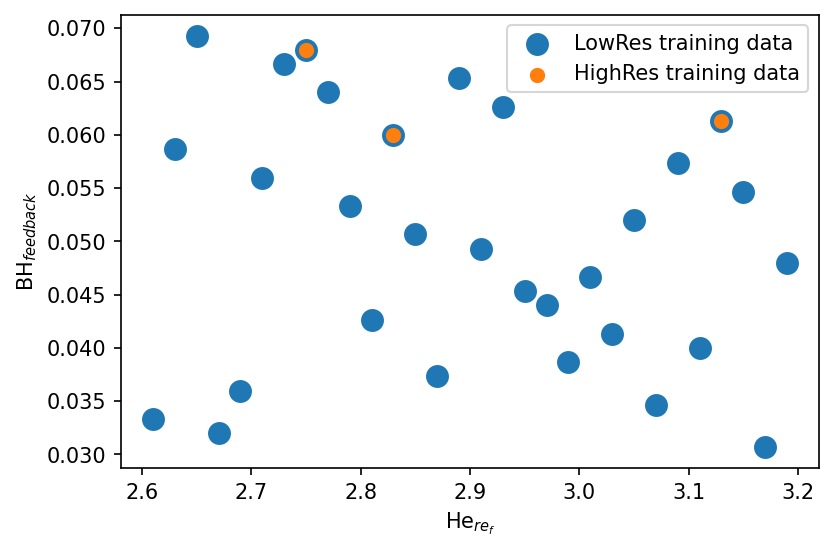

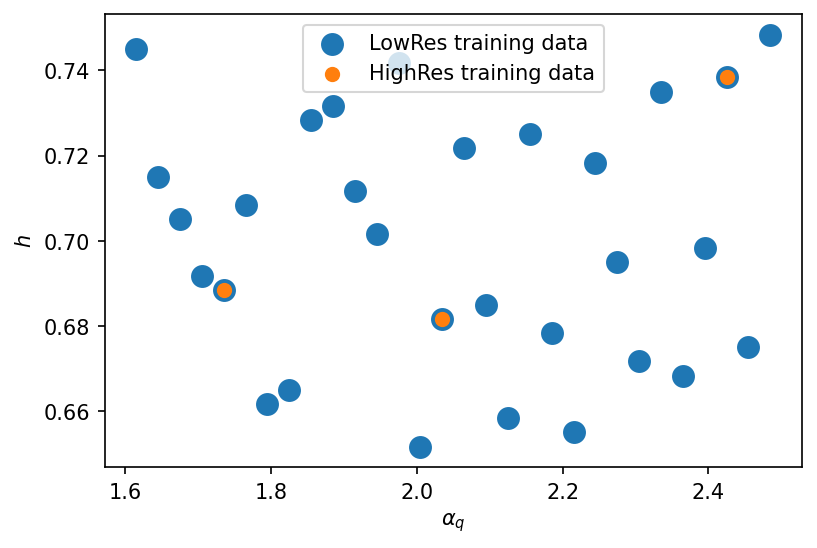

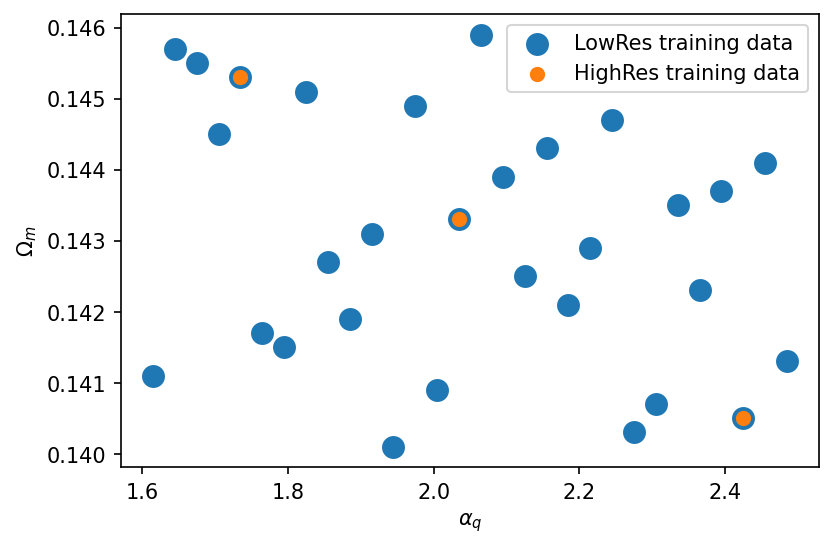

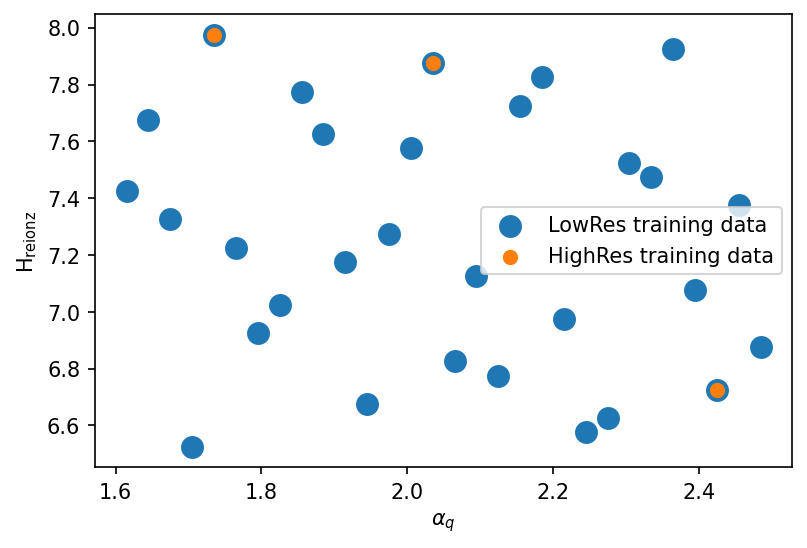

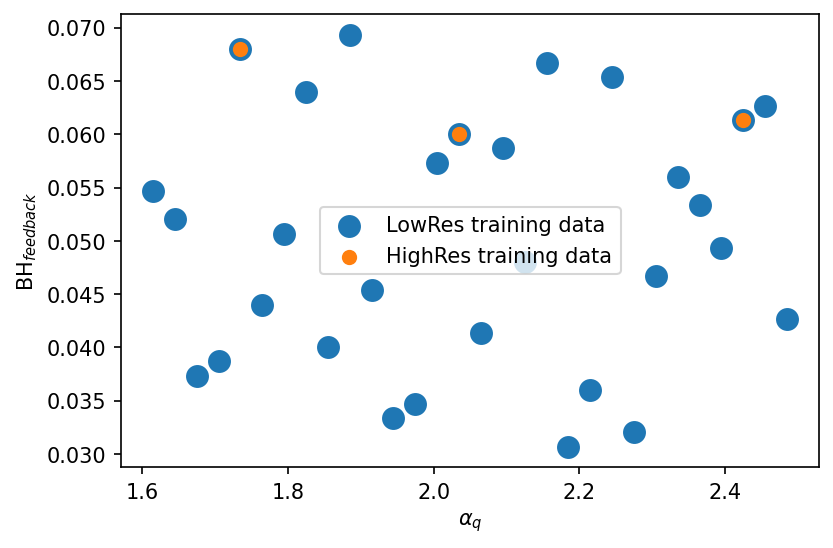

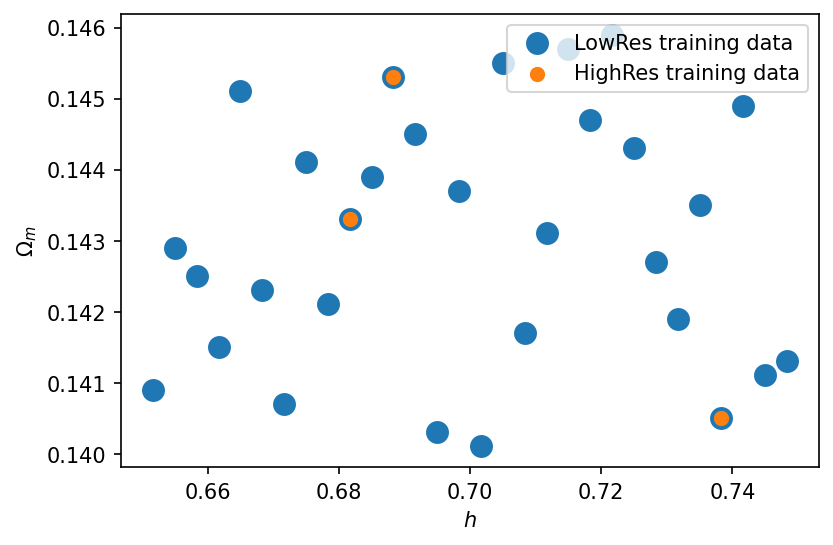

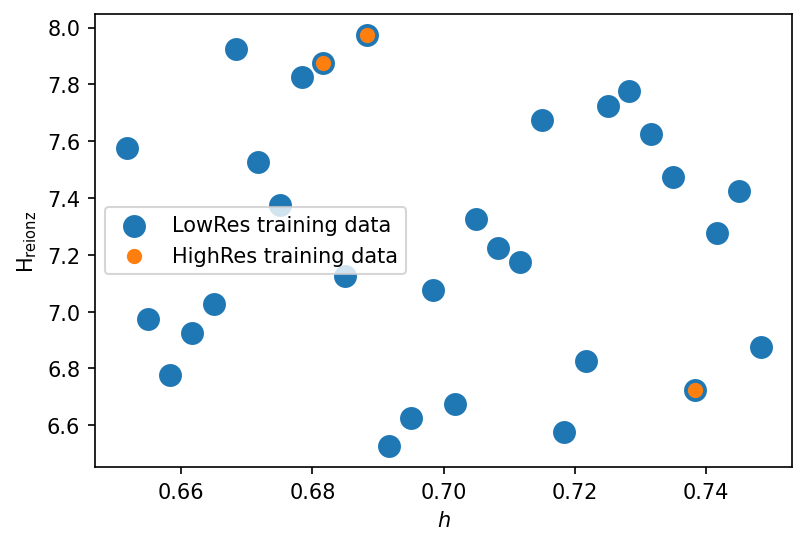

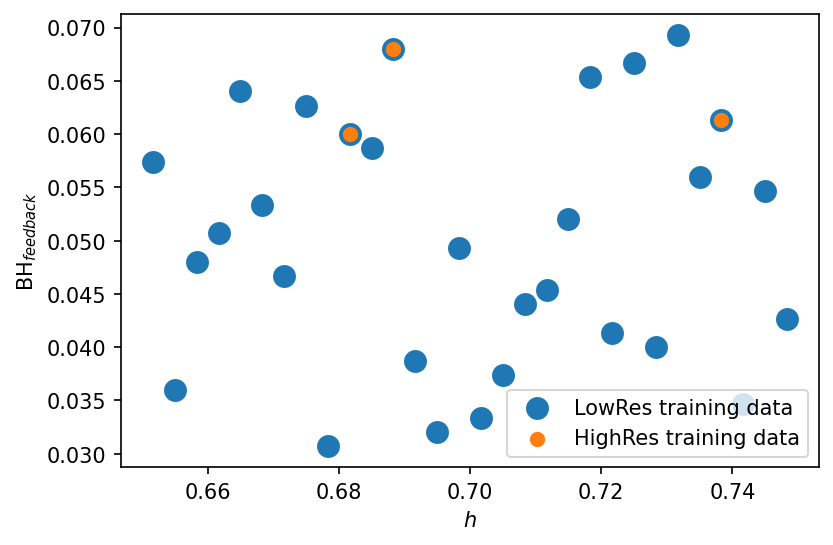

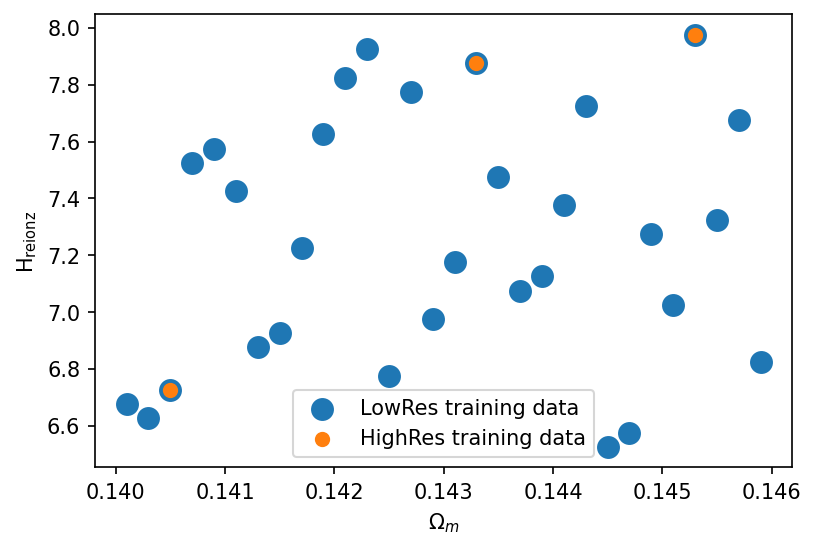

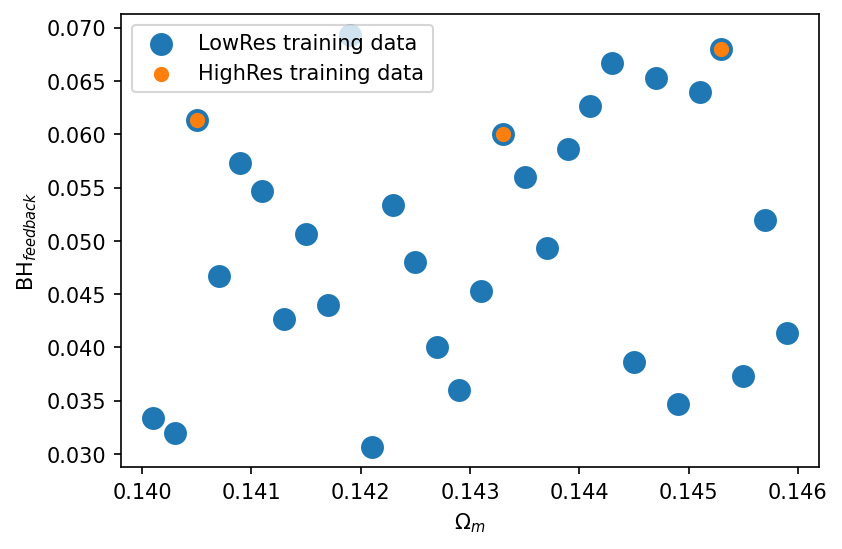

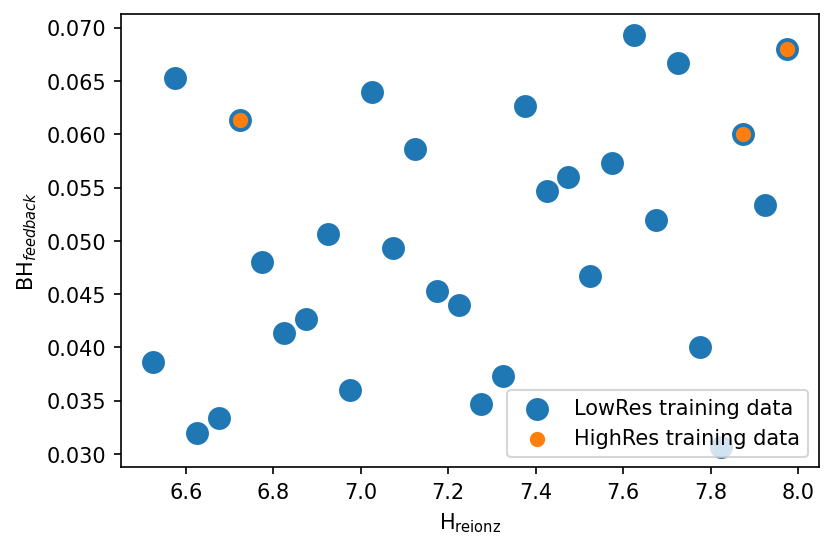

In [26]:
# directly search for optimal three
# summing over all redshifts
plot_parameters([X_train, X_train[selected_index_sum_z_3]])